# Import needed libraries

In [1]:
!pip install gurobipy --upgrade
!pip install pyqubo --upgrade
!pip install dwave-ocean-sdk
!pip install qiskit --upgrade
!pip install qiskit-optimization
!pip install qiskit-optimization[cplex]
!pip install qiskit-aer
!pip install qiskit-ibmq-provider
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import sys
import time
from collections import defaultdict
import re # to extract numbers from strings
import copy

import numpy as np
from numpy import linalg as la
import networkx as nx
from networkx import community
import matplotlib
import matplotlib.pyplot as plt

# Gurobi libraries
import gurobipy as gp
from gurobipy import GRB

# DWave libraries
import dwave.cloud as dc
from dwave.cloud import Client
from dwave.system.samplers import DWaveSampler, LeapHybridSampler
from dwave.system.composites import EmbeddingComposite
import dimod
from dimod import BinaryQuadraticModel
import neal

# Library to prepare QUBO formulation
from pyqubo import Array, Binary, Constraint, LogEncInteger

# Qiskit libraries
import pylab
from qiskit.visualization import plot_distribution
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, Parameter

# Qiskit Primitives: Sampler, Estimator and Backend
from qiskit.primitives import Sampler, BackendSampler
from qiskit import Aer
from qiskit import IBMQ
# from qiskit.providers.aer import AerSimulator
# from qiskit_ibm_provider import IBMProvider

# Qiskit Optimization
import qiskit_optimization
from qiskit_optimization import QuadraticProgram
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE, QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer, GurobiOptimizer, CobylaOptimizer, WarmStartQAOAOptimizer
from qiskit.algorithms.optimizers import ADAM, AQGD, CG, COBYLA, L_BFGS_B, GradientDescent, NELDER_MEAD, NFT, P_BFGS, POWELL, SLSQP, SPSA, QNSPSA, TNC, SciPyOptimizer, UMDA

<ipython-input-2-61460f5c67a3>:47: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA, COBYLA


# Connect to DWave and choose solver

In [3]:
token = ''
endpoint = 'https://cloud.dwavesys.com/sapi'

In [4]:
# Set your D-Wave API token and endpoint URL
config = {
    'token': token,
    'endpoint': endpoint,
}

# Connect to the D-Wave system
client = dc.Client.from_config(**config)

# Print the available samplers and their names
for solver in client.get_solvers():
    print("Solver Name:", solver.id)

Solver Name: hybrid_binary_quadratic_model_version2
Solver Name: hybrid_discrete_quadratic_model_version1
Solver Name: Advantage_system4.1
Solver Name: hybrid_constrained_quadratic_model_version1
Solver Name: Advantage2_prototype1.1
Solver Name: Advantage_system6.2


In [5]:
# Specify the DWave solver name we want to use
solver = 'hybrid_binary_quadratic_model_version2'
# solver = 'Advantage_system6.2'

# Set your D-Wave API token and endpoint URL
config = {
    'token': token,
    'endpoint': endpoint,
    'solver': solver
}

# choose the sampler
# Simulated Annealing (classic sampler)
sampler = neal.SimulatedAnnealingSampler()
solver = 'SimulAnneal'

# hybrid sampler
# sampler = LeapHybridSampler(**config)

# # DWave sampler (pure quantum)
# sampler = DWaveSampler(**config)
# sampler = EmbeddingComposite(sampler) # DWave built-in embedding strategy
# # Create a D-Wave cloud client
# client = Client(**config)
# # Connect to the QPU
# qpu = client.get_solver()

# Connect to IBM-Quantum and choose backend

In [6]:
# LIST OF IBM-QUANTUM BACKENDS

# Load your IBM Quantum Experience account
IBMQ_token = ''
IBMQ.save_account(IBMQ_token)
IBMQ.load_account()

# Get a list of available backends (real quantum devices and simulators)
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
simulator_backends = provider.backends(simulator=True)  # only Simulators
quantum_backends = provider.backends(simulator=False) # only real Quantum devices

# Select the backend you want to use (e.g., the first available one)
print('\nSimulators')
for backend in simulator_backends:
  print(backend)

print('\nQuantum devices')
for backend in quantum_backends:
  print(backend)

<ipython-input-6-daaa339f4b7a>:5: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account(IBMQ_token)
<ipython-input-6-daaa339f4b7a>:5: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account(IBMQ_token)



Simulators
ibmq_qasm_simulator
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer

Quantum devices
ibmq_lima
ibmq_belem
ibmq_quito
ibmq_jakarta
ibmq_manila
ibm_lagos
ibm_nairobi
ibm_perth


In [7]:
# LIST OF QISKIT AER BACKENDS

# Get the list of available backends from Aer
aer_backends = Aer.backends()

# Print the names of the backends
for backend in aer_backends:
    print(backend.name())

aer_simulator
aer_simulator_statevector
aer_simulator_density_matrix
aer_simulator_stabilizer
aer_simulator_matrix_product_state
aer_simulator_extended_stabilizer
aer_simulator_unitary
aer_simulator_superop
qasm_simulator
statevector_simulator
unitary_simulator
pulse_simulator


In [8]:
# choose the backend on which to run VQE and QAOA

# # select IBM-Quantum backend
# backend_name = 'ibmq_qasm_simulator'
# backend = provider.get_backend(backend_name)

# select Aer backend
backend_name = 'aer_simulator_statevector'
backend = Aer.get_backend(backend_name)

In [9]:
# callback function to print the optimization progress
counts_callback = []
values_callback = []
best_params = None
best_evaluation = float('inf')

def store_intermediate_result(eval_count, parameters, mean, std):
  counts_callback.append(eval_count)
  values_callback.append(mean)
  global best_params, best_evaluation
  if mean < best_evaluation:
    best_evaluation = mean
    best_params = parameters

# set random seed for classic simulation
seed = 10598
algorithm_globals.random_seed = seed

# Create the Sampler with the specified backend
qiskit_sampler = BackendSampler(backend=backend)

# Generate a random graph

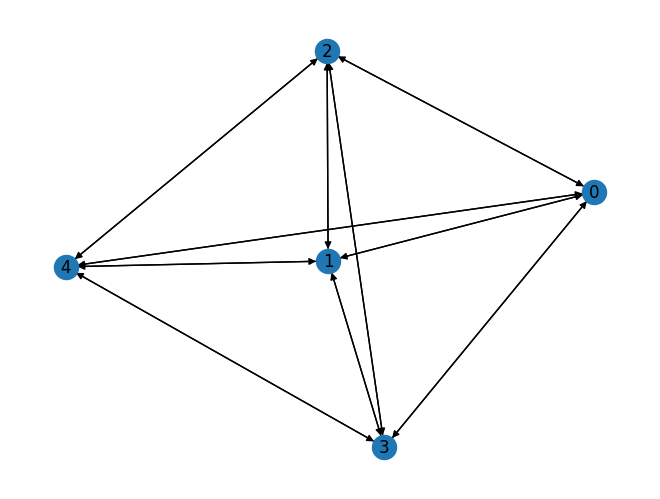

In [10]:
# number of nodes
n = 5

# since we want to solve basic VRP without taking into account capacities,
# we fix the maximum capacity C = n and customers' demands d = (1, ..., 1)
# this allows the vehicles to possibly visit all nodes,
# without restricting the routes

# maximum vehicle Capacity
C = n

# customers' demand
d = np.ones(n)
d[0] = 0

# heuristich bound of the number of vehicles needed to serve all customers
# To obtain the exact k_min we would need to solve a Bin Packing Problem
# Regardless, the heuristic bound usually works well too
kmin = int(np.ceil(np.sum(d)/C))

# number of vehicles
k = kmin + 1

# generate random Adjacency matrix
# first generate a random matrix where each entry is i.i.d. ~ Ber(p) with p = graph_density.
# Then assign the edges random weights i.i.d. ~ U({0,...,10})
graph_density = 3/3
E = np.multiply(np.random.binomial(1, p=graph_density, size=(n, n)),
                np.random.randint(0, 10, size=(n, n)))
# make it symmetrical (to avoid getting stuck in dead ends)
E = E + E.T
# take away the diagonal
E = E - np.diag(np.diag(E))

# generate graph from Adjacency matrix
G = nx.from_numpy_array(E, create_using=nx.DiGraph)

# fix depot node
depot = 0

# draw Graph using Fruchterman-Reingold force-directed algorithm
nx.draw(G, nx.spring_layout(G), with_labels=True)

In [11]:
E

array([[ 0, 15, 11,  8,  5],
       [15,  0, 17, 15,  7],
       [11, 17,  0, 11,  9],
       [ 8, 15, 11,  0, 11],
       [ 5,  7,  9, 11,  0]])

# Useful functions

## Build route from (node, timestep) tuples

In [12]:
def build_route_node_time(route, cluster):

  # sort the tuples (node, timestep) wrt timestep
  route.sort(key=lambda x: x[1])

  print(route)

  # check if route is a valid routing
  # each node in the cluster must be visited exactly once
  for node in cluster:
    cont = sum([1 for tpl in route if tpl[0]==node])
    if cont!=1:
      print('Not a valid routing: node visited more than once')
      return (route, False)

  # only one node must be visited per timestep
  for timestep in range(len(cluster)):
    cont = sum([1 for tpl in route if tpl[1]==timestep])
    if cont!=1:
      print('Not a valid routing: more than one node per timestep')
      return (route, False)

  route = [tpl[0] for tpl in route]
  return (route, True)

## TPS-2 Gurobi

In [13]:
def TSP2_gurobi(cluster):

  cluster = set(cluster)
  n = len(cluster)

  # Declare and initialize model
  m = gp.Model('TSP2')

  # node-time variables
  x = {}
  for i in cluster:
    for t in range(len(cluster)):
      x[(i,t)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{t}]")

  # update model
  m.update()

  # each node only once
  m.addConstrs((sum(x[(i, t)] for t in range(len(cluster))) == 1 for i in cluster), name='each_node_only_once')
  # only one node per timestep
  m.addConstrs((sum(x[(i, t)] for i in cluster) == 1 for t in range(len(cluster))), name='one_node_per_timestep')

  # update model
  m.update()

  # Objective: minimize total cost of all assignments
  obj = np.sum([E[i,j]*x[(i,t)]*x[(j,t+1)]
                for i in cluster
                for j in cluster
                for t in range(len(cluster)-1)
                if E[i,j]!=0 and i!=j])

  m.setObjective(obj, GRB.MINIMIZE)

  # update model
  m.update()

  # Save model for inspection
  m.write('TSP2_gurobi.lp')

  # Run optimization engine
  m.optimize()

  # get route
  route = []
  for v in m.getVars():
    if v.varName[0]=='x' and v.x > 1e-6:
      nodes_time = re.findall(r'\d+', v.varName)
      route.append((int(nodes_time[0]), int(nodes_time[1])))

  route, is_valid = build_route_node_time(route, cluster)

  # compute final objective function value
  obj = np.sum([E[i,j]*x[(i,t)].X*x[(j,t+1)].X
                for i in cluster
                for j in cluster
                for t in range(len(cluster)-1)
                if E[i,j]!=0 and i!=j]) + E[route[-1], route[0]]

  return (is_valid, route, obj)

## TSP-2 GAMA

In [14]:
def TSP2_gama(cluster):

################################################################################

  # useful function for Graver Augmentation

  # Objective function definition
  def f(x):
    y = x.copy()
    y = y.reshape((len(cluster), len(cluster)))
    obj_fun = sum(E[list(cluster)[i], list(cluster)[j]]*y[i,t]*y[j,t+1]
                for i in range(len(cluster))
                for j in range(len(cluster))
                for t in range(len(cluster)-1)
                if i!=j and E[list(cluster)[i], list(cluster)[j]]!=0)

    return obj_fun

  # Constraints satisfaction
  def const(x):
      return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

################################################################################

  cluster = set(cluster)
  n = len(cluster)

  # Declare and initialize model
  m = gp.Model('TSP2_GAMA')
  # m.Params.LogToConsole = 0

  # node-time variables
  x = {}
  for i in cluster:
    for t in range(len(cluster)):
      x[(i,t)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{t}]")

  # update model
  m.update()

  # each node only once
  m.addConstrs((sum(x[(i, t)] for t in range(len(cluster))) == 1 for i in cluster), name='each_node_only_once')
  # only one node per timestep
  m.addConstrs((sum(x[(i, t)] for i in cluster) == 1 for t in range(len(cluster))), name='one_node_per_timestep')

  # update model
  m.update()

  # Objective: minimize total cost of all assignments
  obj = np.sum([E[i,j]*x[(i,t)]*x[(j,t+1)]
                for i in cluster
                for j in cluster
                for t in range(len(cluster)-1)
                if E[i,j]!=0 and i!=j])

  m.setObjective(obj, GRB.MINIMIZE)

  # update model
  m.update()

  # Save model for inspection
  m.write('TSP2_GAMA.lp')

  # Run optimization engine
  A = m.getA()
  A = A.toarray()
  b = np.array(m.getAttr("RHS", m.getConstrs()), int)

  # create GAMA variables
  x = Array.create('x', shape=(A.shape[1]), vartype='BINARY')

  # compute graver basis elements
  graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
  # print(len(graver_elems), ' graver elements found.')

  # compute feasible solutions
  feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
  # print(len(feas_sols), ' feasible solutions found.')

  # Multiseed Augmentation
  final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

  # get best solution
  x_opt = final_sols[np.argmin(final_obj_full), :]

  # get route
  route = []
  for i in cluster:
    for t in range(len(cluster)):
      route.append((i,t))

  route = [route[i] for i in range(len(route)) if x_opt[i]>1e-6]

  route, is_valid = build_route_node_time(route, cluster)

  # compute final objective function value
  obj = f(x_opt) + E[route[-1], route[0]]
  return (is_valid, route, obj)

## TSP-2 QUBO

In [15]:
def TSP2_qubo_VQA(cluster, p = np.sum(E)+1, classic_optimizer=SPSA, maxiter=200, VQA='Numpy', circuit_depth=1, show_hist=False):

  cluster = set(cluster)
  n = len(cluster)
  M = 1e6

  # node-time QUBO variables
  x = {}
  for i in cluster:
    for t in range(len(cluster)):
      x[(i,t)] = Binary(f'x[{i},{t}]')

  # build QUBO by manually adding objective and constraints

  # define objective function
  obj = np.sum([E[i,j]*x[(i,t)]*x[(j,t+1)]
                for i in cluster
                for j in cluster
                for t in range(len(cluster)-1)
                if E[i,j]!=0 and i!=j])

  # add the objective
  Q =  obj

  # add the constraints
  # only one timestep per node
  Q += p*sum([Constraint((sum([x[(i, t)] for t in range(len(cluster))])-1)**2, label=f'one_timestep_per_node{i}') for i in cluster])

  # only one node per timestep
  Q += p*sum([Constraint((sum([x[(i, t)] for i in cluster])-1)**2, label=f'one_node_per_timestep{t}') for t in range(len(cluster))])

  # get QUBO matrix
  model = Q.compile()
  Q_dict, offset = model.to_qubo()

  # Convert QUBO to Qiskit Quadratic Program
  qp = QUBO_to_QuadProg(Q_dict)

  # print(qp.prettyprint())

  # Solve via Variational Quantum Algorithms
  # # Choose the classical optimizer
  # classic_optimizer = SPSA(maxiter=maxiter)

  # Lists used by callback to store optimization progress
  counts_callback = []
  values_callback = []

  # Choose Variational Quantum Algorithm
  if VQA=='Numpy':
    vqa = NumPyMinimumEigensolver()
  elif VQA=='VQE':
    ansatz = RealAmplitudes(reps=circuit_depth)  # VQE ansatz
    vqa = SamplingVQE(qiskit_sampler, ansatz=ansatz, optimizer=classic_optimizer(maxiter), callback=store_intermediate_result)
  elif VQA=='QAOA':
    vqa = QAOA(qiskit_sampler, reps=circuit_depth, optimizer=classic_optimizer(maxiter), callback=store_intermediate_result)

  # Run VQA optimization
  optimizer = MinimumEigenOptimizer(vqa)
  result = optimizer.solve(qp)

  # get best_sample's edges
  route = []
  for i in cluster:
    for t in range(len(cluster)):
      if result.x[qp.variables_index[f'x[{i},{t}]']] > 1e-6:
        route.append((i, t))

  route, is_valid = build_route_node_time(route, cluster)

  # compute final objective function value
  obj = np.sum([E[i,j]*result.x[qp.variables_index[f'x[{i},{t}]']]*result.x[qp.variables_index[f'x[{j},{t+1}]']]
                for i in cluster
                for j in cluster
                for t in range(len(cluster)-1)
                if E[i,j]!=0 and i!=j]) + E[route[-1], route[0]]

  if show_hist==True:
    plot_solutions_distribution_VQA(qp, result, cluster, problem='routing2')

  return (is_valid, route, obj)

In [16]:
def TSP2_qubo(cluster, p = np.sum(E)+1, show_hist=False):

  cluster = set(cluster)
  n = len(cluster)

  # node-time QUBO variables
  x = {}
  for i in cluster:
    for t in range(len(cluster)):
      x[(i,t)] =  Binary(f'x[{i},{t}]')

  # build QUBO by manually adding objective and constraints

  # define objective function
  obj = np.sum([E[i,j]*x[(i,t)]*x[(j,t+1)]
                for i in cluster
                for j in cluster
                for t in range(len(cluster)-1)
                if E[i,j]!=0 and i!=j])

  # add the objective
  Q =  obj

  # add the constraints
  # only one timestep per node
  Q += p*sum([Constraint((sum([x[(i, t)] for t in range(len(cluster))])-1)**2, label=f'one_timestep_per_node{i}') for i in cluster])

  # only one node per timestep
  Q += p*sum([Constraint((sum([x[(i, t)] for i in cluster])-1)**2, label=f'one_node_per_timestep{t}') for t in range(len(cluster))])

  # get QUBO matrix
  model = Q.compile()
  Q_dict, offset = model.to_qubo()

  # solve the model with the chosen sampler
  if solver=='SimulAnneal':   # classic solver
    sampleset = sampler.sample_qubo(Q_dict, num_reads=300, num_steps=1000)
  elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
    sampleset = sampler.sample_qubo(Q_dict)
  elif solver=='Advantage_system6.2':   # quantum solver
    sampleset = sampler.sample_qubo(Q_dict, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])

  # get obtained solutions
  samples = model.decode_sampleset(sampleset)

  if show_hist==True:
    plot_solutions_distribution(samples, cluster, problem='routing2')

  # take only valid solutions (actual routes)
  samples = [s for s in samples if is_feasible_node_time(s.sample, s.energy, cluster)==True]

  # take only best solution (feasible and with minimum energy)
  best_sample = min(samples, key=lambda s: s.energy)

  # get best_sample's edges
  route = []
  for i in cluster:
    for t in range(len(cluster)):
      if best_sample.sample[f'x[{i},{t}]'] > 1e-6:
        route.append((i, t))

  route, is_valid = build_route_node_time(route, cluster)

  # compute final objective function value
  obj = np.sum([E[i,j]*best_sample.sample[f'x[{i},{t}]']*best_sample.sample[f'x[{j},{t+1}]']
                for i in cluster
                for j in cluster
                for t in range(len(cluster)-1)
                if E[i,j]!=0 and i!=j]) + E[route[-1], route[0]]

  return (is_valid, route, obj)

In [17]:
def is_feasible_node_time(sample, energy, cluster):

  # original objective function value
  obj = np.sum([E[i,j]*sample[f'x[{i},{t}]']*sample[f'x[{j},{t+1}]']
                for i in cluster
                for j in cluster
                for t in range(len(cluster)-1)
                if E[i,j]!=0 and i!=j])

  return obj==energy

## Custom Louvain for clustering phase

In [18]:
# we want to cluster nodes based on distances, specifically
# we want nodes in the same cluster to have a small overall distance
# in order to reduce TSP objective. To do this, we define a new Graph
# where weights are exp(-weight) of the original weights (which are indeed distances).
# We do this because in Modularity Maximization A[i,j] is interpreted as
# similarity value between nodes (i,j). In this sense, nodes with higher similarity
# will tend to be clustered together. In our case however A[i,j] is the distance
# between nodes (i,j), but we dont want to cluster together far distanced node.
# On the contrary, we want nodes in the same cluster to be at small distances from
# one another. That's why we define E_inv and the new 'inverted' graph G_inv

E_inv = np.zeros(E.shape)
for i in range(E_inv.shape[0]):
  for j in range(E_inv.shape[1]):
    if E[i,j]!=0:
      E_inv[i,j] = np.exp(-E[i,j])

# generate graph from Adjacency matrix
G_inv = nx.from_numpy_array(E_inv, create_using=nx.DiGraph)

In [19]:
# greedy community detection
# A modified version of Louvain greedy algorithm where we now include also
# capacity constraints in community generation.
# Namely, a community cannot have nodes such that communty total demand exceed the
# community capacity
def greedy_community_detection(G, k, C, demands):

  E_condensed = E_inv
  num_nodes = n

  communities = {}
  for i in range(num_nodes):
    communities[i] = i

  # build partition
  partition = [[vertex for vertex in range(n) if communities[vertex]==comm_id] for comm_id in set(list(communities.values()))]
  # compute modularity
  modularity = nx.community.modularity(G, partition, weight='weight', resolution=1)
  initial_mod = modularity
  # keep repeting the process as long as the modularity
  modularity_increased = True

  # print(initial_mod)

  while modularity_increased==True:

    modularity = initial_mod

    # randomly shuffle the nodes
    permuted_nodes = np.random.permutation(num_nodes)

    for node in permuted_nodes:
      # print('\t', node)
      best_neighbor = node
      # compute neighboring nodes
      neighbors = [neigh for neigh in range(num_nodes) if E_condensed[node, neigh]>0]
      # we add the node itself as neighbor so that the community
      # is preserved if it is not convenient to merge the node with any
      # of its neighbors
      neighbors.append(node)
      # for each neighbor, try to merge the node with the neighbor
      # keep only the merging attaining maximum modularity
      for neigh in neighbors:
        comms = copy.deepcopy(communities) # used to temporaly merge communities
        nodes = [key for key in list(communities.keys()) if communities[key]==communities[node]]
        for v in nodes:
          comms[v] = comms[neigh]

        community_capacity = sum([d[i] for i in range(n) if comms[i]==comms[neigh]])

        # build partition
        new_partition = [[vertex for vertex in range(n) if comms[vertex]==comm_id] for comm_id in set(list(comms.values()))]
        # compute modularity
        new_modularity = nx.community.modularity(G, new_partition, weight='weight', resolution=1)
        # keep only the merging attaining maximum modularity
        if new_modularity > modularity and community_capacity<=C:
          best_neighbor = neigh
          modularity = new_modularity

      #   print(node, neigh, modularity, new_partition, new_modularity, '\n')

      # print(node, best_neighbor, modularity)

      nodes = [key for key in list(communities.keys()) if communities[key]==communities[node]]
      for v in nodes:
        communities[v] = communities[best_neighbor]

      partition = [[vertex for vertex in range(n) if communities[vertex]==comm_id] for comm_id in set(list(communities.values()))]
      new_modularity = nx.community.modularity(G, partition, weight='weight', resolution=1)
      # print(partition)
      # print(new_modularity)

    # print(communities)

    # update dictionary values
    values = list(set(list(communities.values())))
    for i in range(len(values)):
      keys = [key for key in list(communities.keys()) if communities[key]==values[i]]
      for key in keys:
        communities[key] = i

    # define the condensed graph and start again
    num_comms = len(set(list(communities.values())))
    num_nodes = num_comms
    E_condensed = np.zeros(shape = (num_comms, num_comms))
    for i in range(E_condensed.shape[0]):
      for j in range(E_condensed.shape[1]):
        E_condensed[i,j] = sum([E_inv[source, target] for source in range(n) for target in range(n)
                                if communities[source]==i and communities[target]==j])

    partition = [[vertex for vertex in range(n) if communities[vertex]==comm_id] for comm_id in set(list(communities.values()))]
    new_modularity = nx.community.modularity(G, partition, weight='weight', resolution=1)

    # print(partition)
    # print(initial_mod, new_modularity)

    if new_modularity>initial_mod:
      modularity_increased=True
      initial_mod = new_modularity
    else:
      modularity_increased=False

  # compute final communities
  partition = [[vertex for vertex in range(n) if communities[vertex]==comm_id] for comm_id in set(list(communities.values()))]
  communities = reduce_communities(G, partition, k)
  communities = check_depot_connection(G, communities)

  return communities

In [20]:
# if the number of communities exceeds k then we greedly move nodes so the
# reduce the number down to k. Important: we want the minimum possible
# decrease in modularity and also capacity constraints must not be violated.
# At each iteration we determine the most sparse community (which thus has lowest
# impact on overall modularity) and from such community we take the least connected node
# (which thus has lowest impact on the community modularity).
# We then insert such node in another community, where such community is chosen
# so that the insertion would have smallest impact on overall modularity.
# Beware: before inserting the node we must check it has connections in the new community
# and also that capacity constraints are not violated.

def reduce_communities(G, communities, k):
  while len(communities) > k:
    # print(len(communities), k)
    initial_modularity = nx.community.modularity(G, communities, weight='weight', resolution=1)
    # print('start', communities)
    communities = [community for community in communities if len(community)>0]
    # print('filtered', communities)
    community = find_least_connected_community(communities)
    # print('lcc', community)
    least_connected_node = find_least_connected_node(community)
    # print('lcn', least_connected_node)
    i = communities.index(community)
    # print('index', i)
    modularity_decrease = float('inf')
    for j, other_community in enumerate(communities):
      if i!=j and len([node for node in other_community if E_inv[node, least_connected_node]!=0])>0:
        new_communities = copy.deepcopy(communities)
        new_communities[i].remove(least_connected_node)
        new_communities[j].append(least_connected_node)
        modularity = nx.community.modularity(G, new_communities, weight='weight', resolution=1)
        community_capacity = sum([d[node] for node in new_communities[j]])
        if initial_modularity - modularity < modularity_decrease and community_capacity<=C:
          target_comm = j
          modularity_decrease = initial_modularity - modularity
    # print(target_comm)
    communities[i].remove(least_connected_node)
    communities[target_comm].append(least_connected_node)

  return communities



def find_least_connected_node(community):
  least_connected_node = None
  min_degree = float('inf')
  for node in community:
    degree = sum([E_inv[node, neigh] for neigh in community])
    if degree < min_degree:
      least_connected_node = node
      min_degree = degree
  return least_connected_node

def find_least_connected_community(communities):
  min = float('inf')
  for community in communities:
    density = sum([E_inv[i,j] for i in community for j in community])
    if density < min:
      least_connected_community = community
      min = density
  return least_connected_community

In [21]:
# all the communities must have at leat a node connected to the depot
# if that is not the case we manually move nodes so to connect each community
# to the depot while also providing smallest loss in modularity and
# capacity constraint satisfaction

# from each community not connected to the depot we take the lowest connected node in the community,
# we then want to swap such node with a depot-connected node of an other community.
# Beware: in swapping the nodes we must check that the nodes have connections in their new
# communities, otherwise isolated point would emerge. Moreover, che capacity constraints
# on both communities must still be satisfied after the swapping is complete.
# To choose the depot connected community on which to perform the swap we use a greedy approach,
# testing all the communities and choosing the one whose swap would result in
# minimum modularity deterioration

def check_depot_connection(G, communities):

  # for each community count the number of connection to the depot
  count_connection_to_depot = [sum([1 for node in community if E_inv[0, node]!=0]) for community in communities]

  # if every community has at least a node connected to the depot then we are good
  if 0 not in count_connection_to_depot:
    return communities

  # compute initial modularity
  initial_modularity = nx.community.modularity(G, communities, weight='weight', resolution=1)

  # repeat as long as there are communities not connected to the depot
  while 0 in count_connection_to_depot:

    # get community with no connections to the depot
    i = count_connection_to_depot.index(0)    # index of the depot not-connected community

    # from depot not-connected community we want to take the node which has the
    # lowest connectivity with other nodes in the community
    lowest_connectivity = []
    for node in communities[i]:
      degree = sum([E_inv[node, j] for j in communities[i]])
      lowest_connectivity.append((node, degree))
    lowest_connectivity.sort(key=lambda x: x[1])

    # we implement greedy swaps based on mimimum modularity deterioration
    modularity_decrease = float('inf')

    # Beware: we cannot swap nodes with communities which have only
    # one connection to the depot, as it that case after swapping the community
    # would remain without connection to the depot
    for j, other_community in enumerate(communities):
      if i!=j and count_connection_to_depot[j]>=2:
        # we want to take the depot-connected node which has the lowest connectivity with other nodes in the community
        depot_connectivity = []
        for node in other_community:
          if E_inv[node, 0]+E_inv[0, node]>0:
            degree = sum([E_inv[node, j] for j in other_community])
            depot_connectivity.append((node, degree))
        depot_connectivity.sort(key=lambda x: x[1])  # sorts in place

        for node_1 in [lcn[0] for lcn in lowest_connectivity]:    # lcn = least connected node
          for node_2 in [dlcn[0] for dlcn in depot_connectivity]:   # dlcn = depot least connected node

            # check wether the nodes have connections in case of swap
            if len([vertex for vertex in other_community if E_inv[node_1, vertex]!=0])>0 and len([vertex for vertex in communities[i] if E_inv[node_2, vertex]!=0])>0:

              new_communities = copy.deepcopy(communities)

              # substitute node_1 in original community
              # with node_2, which is depot connected
              new_communities[i].remove(node_1)
              new_communities[i].append(node_2)

              # substitute node_2 in depot connected community
              # with node_1 from depot not-connected community
              new_communities[j].remove(node_2)
              new_communities[j].append(node_1)

              # compute new modularity
              modularity = nx.community.modularity(G, new_communities, weight='weight', resolution=1)

              # compute capacity of the new communities
              community_capacity_i = sum([d[node] for node in new_communities[i]])
              community_capacity_j = sum([d[node] for node in new_communities[j]])

              if initial_modularity - modularity < modularity_decrease and community_capacity_i <=C and community_capacity_j <=C:   # capacity constraint
                source_node = node_1
                target_node = node_2
                target_comm = j
                modularity_decrease = initial_modularity - modularity
                break
            break

    # print(target_comm)
    communities[i].remove(source_node)
    communities[i].append(target_node)
    communities[target_comm].remove(target_node)
    communities[target_comm].append(source_node)

    # for each community count the number of connection to the depot
    count_connection_to_depot = [sum([1 for node in community if E_inv[0, node]!=0]) for community in communities]

  return communities

In [22]:
# all the communities must satisfy capacity constraints

# from each community exceeding the capacity constraint we take the lowest connected node in the community,
# we then want to move such node to an other community (satisfying CCs) while ensuring CCs are still satisfied.
# Beware: in moving the nodes we must check that the nodes have connections in their new
# communities, otherwise isolated point would emerge.
# To choose the community to which move the node we use a greedy approach,
# testing all the communities and choosing the one which would result in
# minimum modularity deterioration

def check_capacity_constraints(G, communities):

  # for each community check the capacity
  check_capacities = [sum([d[node] for node in community]) for community in communities]

  # if every community satisfies CCs then we are good
  if len([1 for c in check_capacities if c>C])==0:
    return communities

  # compute initial modularity
  initial_modularity = nx.community.modularity(G, communities, weight='weight', resolution=1)

  # repeat as long as there are communities not satisfying the CC
  while len([1 for c in check_capacities if c>C])>0:

    # get community not satisfying CCs
    for j in range(len(communities)):
      if sum([d[node] for node in communities[j]])>C:
        i = j   # index of the community not adhering to CCs

    # from such community we want to take the node which has the
    # lowest connectivity with other nodes in the community
    lowest_connectivity = []
    for node in communities[i]:
      degree = sum([E_inv[node, j] for j in communities[i]])
      lowest_connectivity.append((node, degree))
    lowest_connectivity.sort(key=lambda x: x[1])

    # we implement greedy moves based on mimimum modularity deterioration
    modularity_decrease = float('inf')

    for j, other_community in enumerate(communities):
      if i!=j and check_capacities[j]<C:

        for node_1 in [lcn[0] for lcn in lowest_connectivity]:    # lcn = least connected node in the community exceeding CCs

          # check wether the node would have connections in case of move
          if len([vertex for vertex in other_community if E_inv[node_1, vertex]!=0])>0 and check_capacities[j]+d[node_1]<=C:

            new_communities = copy.deepcopy(communities)

            # move node_1 to j-th community
            new_communities[i].remove(node_1)
            new_communities[j].append(node_1)

            # compute new modularity
            modularity = nx.community.modularity(G, new_communities, weight='weight', resolution=1)

            # compute capacity of the new target community
            community_capacity_j = sum([d[node] for node in new_communities[j]])

            if initial_modularity - modularity < modularity_decrease and community_capacity_j <= C:   # capacity constraint
              source_node = node_1
              target_comm = j
              modularity_decrease = initial_modularity - modularity
              break

    # print(target_comm)
    communities[i].remove(source_node)
    communities[target_comm].append(source_node)

    # for each community check the CCs
    check_capacities = [sum([d[node] for node in community]) for community in communities]

  return communities

In [23]:
louvain_clusters = greedy_community_detection(G_inv, k, C, d)
print(louvain_clusters)
nx.community.modularity(G_inv, louvain_clusters, weight='weight', resolution=1)

[[0, 1, 2, 3, 4]]


2.220446049250313e-16

In [24]:
for cluster in louvain_clusters:
  if 0 not in cluster:
    cluster.append(0)
louvain_clusters

[[0, 1, 2, 3, 4]]

In [25]:
# # check if depot_connection works fine (In this runtime nodes 1, 2, 8, are not connected to the depot (25 nodes in total))
# comms = [[1, 2, 8], [0, 6, 7, 4, 10, 14, 15, 19, 22, 23, 21], [3, 5, 9, 12, 17, 18, 20, 24, 11, 16, 13]]
# print(nx.community.modularity(G_inv, comms, weight='weight', resolution=1))
# comms = check_depot_connection(comms)
# print(comms)
# print(nx.community.modularity(G_inv, comms, weight='weight', resolution=1))

In [26]:
louvain = nx.community.louvain_communities(G_inv, weight='weight', resolution=1)
print(louvain)
nx.community.modularity(G_inv, louvain, weight='weight', resolution=1)

[{0, 1, 2, 3, 4}]


2.220446049250313e-16

## Plot VQA solutions distribution

In [27]:
def plot_solutions_distribution_VQA(qp, results, cluster=list(range(n)), problem='routing'):

  hist = {}

  if problem=='routing':
    for s in result.samples:
      x = ''
      for i in cluster:
        for j in cluster:
          if i!=j and E[i,j]!=0:
            x += str(int(s.x[qp.variables_index[f'x[{i},{j}]']]))

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  elif problem=='routing2':
    for s in result.samples:
      x = ''
      for i in cluster:
        for t in range(len(cluster)):
          x += str(int(s.x[qp.variables_index[f'x[{i},{t}]']]))

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  elif problem=='clustering':
    for s in result.samples:
      x = ''
      for v in range(k):
        for i in range(n):
          x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  # Create a matplotlib figure and axes
  fig, ax = plt.subplots()

  plot_distribution(hist, sort='hamming', target_string='0'*len(x), ax=ax)

  # Adjust x-axis label scaling and rotation
  ax.tick_params(axis='x', labelrotation=90, labelsize=5)  # Rotate the x-labels by 90 degrees
  ax.set_xticks(np.arange(len(hist)))  # Set the x-ticks at the positions of the bars
  ax.set_xticklabels(hist.keys())  # Set the x-labels using the keys of the data dictionary

  plt.show()

## Plot QUBO solutions distribution

In [28]:
# plot solutions distribution among feasible QUBO solutions
def plot_solutions_distribution(samples, cluster=list(range(n)), problem='routing'):

  hist = {}

  if problem=='routing':
    for s in samples:
      x = ''
      for i in cluster:
        for j in cluster:
          if i!=j and E[i,j]!=0:
            x += str(s.sample[f'x[{i},{j}]'])

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  elif problem=='routing2':
    for s in samples:
      x = ''
      for i in cluster:
        for t in range(len(cluster)):
          x += str(s.sample[f'x[{i},{t}]'])

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  elif problem=='clustering':
    for s in samples:
      x = ''
      for v in range(k):
        for i in range(n):
          x += str(s.sample[f'z[{v},{i}]'])

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  # Create a matplotlib figure and axes
  fig, ax = plt.subplots()

  plot_distribution(hist, sort='hamming', target_string='0'*len(x), ax=ax)

  # Adjust x-axis label scaling and rotation
  ax.tick_params(axis='x', labelrotation=90, labelsize=5)  # Rotate the x-labels by 90 degrees
  ax.set_xticks(np.arange(len(hist)))  # Set the x-ticks at the positions of the bars
  ax.set_xticklabels(hist.keys())  # Set the x-labels using the keys of the data dictionary

  plt.show()

## QUBO to Qiskit Quadratic Program

In [29]:
def QUBO_to_QuadProg(Q):

  # construct the Quadratic Program using pyqubo dictionaries
  qp = QuadraticProgram()

  # dictionary of linear terms
  linear = {}
  # dictionary of quadratic interactions
  quadratic = {}

  for key in Q.keys():
    if key[0]==key[1]:
      # Add variables
      qp.binary_var(name=key[0])
      linear[key[0]] = Q[key]   # add linear term to the Quadratic Program
    else:
      quadratic[key] = Q[key]   # add quadratic term to the Quadratic Program

  # Add objective
  qp.minimize(constant=offset, linear=linear, quadratic=quadratic)
  # print(qp.prettyprint())

  # # Ising Hamiltonian associated to the Quadratic Program
  # ising_operator = qp.to_ising()

  return qp

## TSP DFJ GAMA

In [30]:
def TSP_DFJ_gama(cluster):

################################################################################

  # useful function for Graver Augmentation

  # Objective function definition
  def f(x):
    return np.sum([obj_coeffs[i]*x[i] for i in range(len(obj_coeffs))])

  # Constraints satisfaction
  def const(x):
      return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

################################################################################

  cluster = set(cluster)
  n = len(cluster)

  # Declare and initialize model
  m = gp.Model('TSP_GAMA')
  # m.Params.LogToConsole = 0

  # edge variables
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

  # dictionary of slack variables for subtour elimination constraint
  s = {}

  # update model
  m.update()

  # only one vehicle on edge (i, j) for every (i, j)
  m.addConstrs((sum(x[(i, j)] for i in cluster if E[i, j]!=0 and i!=j) == 1 for j in cluster), name='enter_node')
  m.addConstrs((sum(x[(i, j)] for j in cluster if E[i, j]!=0 and i!=j) == 1 for i in cluster), name='leave_node')

  # update model
  m.update()

  # Objective: minimize total cost of all assignments
  obj = np.sum([E[i,j]*x[(i,j)]
                for i in cluster
                for j in cluster if E[i,j]!=0 and i!=j])

  m.setObjective(obj, GRB.MINIMIZE)

  # update model
  m.update()

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # count number of found subtours
  cont = 0

  while bool_subtour == True:

    if len(subtour)>0:

        # define slack variable for subtour elimination
      num_var_enc = int(np.ceil(np.log2(sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j])+1)))
      for t in range(num_var_enc):
        s[(cont,t)] = m.addVar(vtype=GRB.BINARY, name=f"s[{cont},{t}]")

      m.update()

      # add subtour elimination constraint
      m.addConstr( -sum(x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j) +
                    (-1 + sum([2**t * s[(cont,t)] for t in range(num_var_enc-1)]) +
                    (sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]) -
                    sum([2**t for t in range(num_var_enc-1)]))*s[(cont, num_var_enc-1)])   # s[cont]
                    == -1.0, name=f'subtour_elimination({cont})')

    # update model
    m.update()

    # Save model for inspection
    m.write('TSP_GAMA.lp')

    # Run optimization engine
    A = m.getA()
    A = A.toarray()
    b = np.array(m.getAttr("RHS", m.getConstrs()), int)
    obj_coeffs = m.getAttr("Obj", m.getVars())

    # compute graver basis elements
    graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
    # print(len(graver_elems), ' graver elements found.')

    # compute feasible solutions
    feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
    # print(len(feas_sols), ' feasible solutions found.')

    # Multiseed Augmentation
    final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

    # get best solution
    x_opt = final_sols[np.argmin(final_obj_full), :]

    # get route
    route = []
    for i in cluster:
      for j in cluster:
        if E[i,j]!=0 and i!=j:
          route.append((i,j))

    route = [route[i] for i in range(len(route)) if x_opt[i]>1e-6]

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  # compute final objective function value
  obj = f(x_opt)
  return (route, obj)

## TSP DFJ QUBO

In [31]:
def TSP_DFJ_qubo_VQA(cluster, p = np.sum(E)+1, classic_optimizer=SPSA, maxiter=200, VQA='Numpy', circuit_depth=1, show_hist=False):

  cluster = set(cluster)
  n = len(cluster)
  M = 1e6

  # create QUBO variables for the edges
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = Binary(f'x[{i},{j}]')

  # ditionary of slack variables for subtour elimination constraints
  s = {}

  # count number of subtours
  cont = 0

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # build QUBO by manually adding objective and constraints

  # define objective function
  obj = sum(E[i,j]*x[(i,j)] for i in cluster for j in cluster if E[i,j]!=0 and i!=j)

  # add the objective
  Q =  obj

  # add the constraints
  # only one edge coming out from each node
  Q += p*sum([Constraint((sum([x[(i, j)] for j in cluster if j!=i and E[i, j]!=0])-1)**2, label=f'leave_node_{i}') for i in cluster])

  # only one edge entering each node
  Q += p*sum([Constraint((sum([x[(i, j)] for i in cluster if i!=j and E[i, j]!=0])-1)**2, label=f'enter_node_{j}') for j in cluster])

  while bool_subtour == True:

    if len(subtour)>0:
      # print(subtour)
      s[cont] = LogEncInteger(f's[{cont}]', (-1, -1 + int(sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]))))
      Q += p*M*(Constraint((-sum([x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]) + s[cont] + 1)**2,
                        label=f'subtour_elimination_{cont}'))
    # get QUBO matrix
    model = Q.compile()
    Q_dict, offset = model.to_qubo()

    # Convert QUBO to Qiskit Quadratic Program
    qp = QUBO_to_QuadProg(Q_dict)

    # print(qp.prettyprint())

    # Solve via Variational Quantum Algorithms
    # # Choose the classical optimizer
    # classic_optimizer = SPSA(maxiter=maxiter)

    # Lists used by callback to store optimization progress
    counts_callback = []
    values_callback = []

    # Choose Variational Quantum Algorithm
    if VQA=='Numpy':
      vqa = NumPyMinimumEigensolver()
    elif VQA=='VQE':
      ansatz = RealAmplitudes(reps=circuit_depth)  # VQE ansatz
      vqa = SamplingVQE(qiskit_sampler, ansatz=ansatz, optimizer=classic_optimizer(maxiter), callback=store_intermediate_result)
    elif VQA=='QAOA':
      vqa = QAOA(qiskit_sampler, reps=circuit_depth, optimizer=classic_optimizer(maxiter), callback=store_intermediate_result)

    # Run VQA optimization
    optimizer = MinimumEigenOptimizer(vqa)
    result = optimizer.solve(qp)

    # get best_sample's edges
    route = []
    for i in cluster:
      for j in cluster:
        if E[i,j]!=0 and i!=j and result.x[qp.variables_index[f'x[{i},{j}]']] > 1e-6:
          route.append((i, j))

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  # compute final objective function value
  obj = np.sum([E[i,j]*result.x[qp.variables_index[f'x[{i},{j}]']]
                  for i in cluster for j in cluster if E[i,j]!=0 and i!=j])

  if show_hist==True:
    plot_solutions_distribution_VQA(qp, result, cluster, problem='routing')

  return (route, obj)

In [32]:
def TSP_DFJ_qubo(cluster, p = np.sum(E)+1, show_hist=False):

  cluster = set(cluster)
  n = len(cluster)

  # create QUBO variables for the edges
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = Binary(f'x[{i},{j}]')

  # ditionary of slack variables for subtour elimination constraints
  s = {}

  # count number of subtours
  cont = 0

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # build QUBO by manually adding objective and constraints

  # define objective function
  obj = sum(E[i,j]*x[(i,j)] for i in cluster for j in cluster if E[i,j]!=0 and i!=j)

  # add the objective
  Q =  obj

  # add the constraints
  # only one edge coming out from each node
  Q += p*sum([Constraint((sum([x[(i, j)] for j in cluster if j!=i and E[i, j]!=0])-1)**2, label=f'leave_node_{i}') for i in cluster])

  # only one edge entering each node
  Q += p*sum([Constraint((sum([x[(i, j)] for i in cluster if i!=j and E[i, j]!=0])-1)**2, label=f'enter_node_{j}') for j in cluster])

  while bool_subtour == True:

    if len(subtour)>0:
        s[cont] = LogEncInteger(f's[{cont}]', (-1, -1 + int(sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]))))
        Q += p*(Constraint((-sum([x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]) + s[cont] + 1)**2,
                          label=f'subtour_elimination_{cont}'))
    # get QUBO matrix
    model = Q.compile()
    Q_dict, offset = model.to_qubo()

    # solve the model with the chosen sampler
    if solver=='SimulAnneal':   # classic solver
      sampleset = sampler.sample_qubo(Q_dict, num_reads=300, num_steps=1000)
    elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
      sampleset = sampler.sample_qubo(Q_dict)
    elif solver=='Advantage_system6.2':   # quantum solver
      sampleset = sampler.sample_qubo(Q_dict, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])

    # get obtained solutions
    samples = model.decode_sampleset(sampleset)

    if show_hist==True:
      plot_solutions_distribution(samples, cluster, problem='routing')

    # take only valid solutions (actual routes)
    samples = [s for s in samples if is_feasible(s.sample, s.energy, cluster)==True]

    # take only best solution (feasible and with minimum energy)
    best_sample = min(samples, key=lambda s: s.energy)

    # get best_sample's edges
    route = []
    for i in cluster:
      for j in cluster:
        if E[i,j]!=0 and i!=j and best_sample.sample[f'x[{i},{j}]'] > 1e-6:
          route.append((i, j))

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  # compute final objective function value
  obj = np.sum([E[i,j]*best_sample.sample[f'x[{i},{j}]']
                  for i in cluster for j in cluster if E[i,j]!=0 and i!=j])

  return (route, obj)

In [33]:
def is_feasible(sample, energy, cluster):

  # original objective function value
  obj = np.sum([E[i,j]*sample[f'x[{i},{j}]']
                for i in cluster
                for j in cluster
                if E[i,j]!=0 and i!=j])

  return obj==energy

## TSP DFJ Gurobi

In [34]:
def TSP_DFJ_gurobi(cluster):

  cluster = set(cluster)
  n = len(cluster)

  # Declare and initialize model
  m = gp.Model('TSP')

  # edge variables
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

  # dictionary of slack variables for subtour elimination constraint
  s = {}

  # update model
  m.update()

  # only one vehicle on edge (i, j) for every (i, j)
  m.addConstrs((sum(x[(i, j)] for i in cluster if E[i, j]!=0 and i!=j) == 1 for j in cluster), name='enter_node')
  m.addConstrs((sum(x[(i, j)] for j in cluster if E[i, j]!=0 and i!=j) == 1 for i in cluster), name='leave_node')

  # update model
  m.update()

  # Objective: minimize total cost of all assignments
  obj = np.sum([E[i,j]*x[(i,j)]
                for i in cluster
                for j in cluster if E[i,j]!=0 and i!=j])

  m.setObjective(obj, GRB.MINIMIZE)

  # update model
  m.update()

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # count number of found subtours
  cont = 0

  while bool_subtour == True:

    if len(subtour)>0:
      # add subtour elimination constraint
      m.addConstr(sum(x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j) >= 1, name='subtour_elimination')

    # update model
    m.update()

    # Save model for inspection
    m.write('TSP_gurobi.lp')

    # Run optimization engine
    m.optimize()

    # get route
    route = []
    for v in m.getVars():
      if v.varName[0]=='x' and v.x > 1e-6:
        nodes_indices = re.findall(r'\d+', v.varName)
        route.append((int(nodes_indices[0]), int(nodes_indices[1])))

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  # compute final objective function value
  obj = np.sum([E[i,j]*x[(i,j)].X
                  for i in cluster
                  for j in cluster if E[i,j]!=0 and i!=j])

  return (route, obj)

## check subtours

In [35]:
def contains_subtours(cluster, edges, VERBOSE=False):

  n = len(cluster)
  routes = []
  unvisited_nodes = list(cluster)

  while len(unvisited_nodes)>0:
    route = []
    initial_node = unvisited_nodes[0]
    route.append(initial_node)
    next_node = [edge[1] for edge in edges if edge[0]==initial_node]
    if len(next_node)!=1:
      print('Not a valid route')
      return
    next_node = next_node[0]
    route.append(next_node)
    while len(route)<n and next_node!=initial_node:
      next_node = [edge[1] for edge in edges if edge[0]==next_node]
      if len(next_node)!=1:
        print('Not a valid route')
        return
      next_node = next_node[0]
      route.append(next_node)
    routes.append(route)

    # update list on not yet visited nodes
    unvisited_nodes = [node for node in unvisited_nodes if route.count(node)==0]

  if len(routes)>1:
    subtour = [route for route in routes if 0 not in route][0]
    if VERBOSE==True:
      print('subtour: \t', subtour)
    return (True, subtour)

  return (False, routes)

## check if clustering is a valid clustering

In [36]:
def is_valid_clustering(clusters, VERBOSE=False):

  # store the clusters
  clustering = []

  # get used vehicles
  vehicles = set([elem[0] for elem in clusters])

  # for each vehicle get the visited customers
  for vehicle in vehicles:
    clustering.append([elem[1] for elem in clusters if elem[0]==vehicle])

  # to be a valid clustering each node must be visited by exactly one vehicle
  # i.e. each node must appear in exactly one cluster
  cont = {}
  for i in range(1, n):
    cont[i] = sum([c.count(i) for c in clustering])
    if cont[i]!=1:
      if VERBOSE==True:
        print('Not a valid clustering: node served by multiple vehicles')
        print(clustering)
      return (False, clustering)

  # Also, the depot must be in each cluster
  cont[0] = sum([c.count(0) for c in clustering])
  if cont[0]!=len(clustering):
    if VERBOSE==True:
      print('Not a valid clustering: depot not in every cluster')
      print(clustering)
    return (False, clustering)

  # Moreover, the capacity of each vehicle must not be exceeded
  for c in clustering:
    if sum([d[node] for node in c])>C:
      if VERBOSE==True:
        print('Not a valid clustering: capacity exceeded')
        print(clustering)
      return (False, clustering)

  if VERBOSE==True:
    print('Valid clustering')
    print(clustering)

  return (True, clustering)

## get clusters from annealing sample

In [37]:
def get_clusters_from_sample(sample):
  clusters = []
  for v in range(k):
    for i in range(n):
      if sample[f'z[{v},{i}]']==1:
        clusters.append((v, i))
  return clusters

## check if feasible solution is an actual route

In [38]:
def is_valid_routing(edges, VERBOSE=False, formulation=1):

  # here we save the final routes (if any)
  routes = []

  # get starting edges of each route
  if formulation==1:
    for edge in edges:    # edge = (node i, node j)
      if edge[0]==0:
        routes.append([edge[0], edge[1]])

    # attempt to build the routes
    for i in range(len(routes)):
      # build route for i-th vehicle
      next_nodes = [edge[1] for edge in edges if edge[0]==routes[i][-1]]
      if next_nodes == []:
        pass
      elif len(next_nodes)>1:   # if we have multiple next_nodes, that means there are multiple edges coming out from the same customer. Infeasible
        if VERBOSE==True:
          print('Not a valid routing')
        return (False, routes)
      else:
        next_node = next_nodes[0]
        routes[i].append(next_node)
        while (len(routes[i])<n) and (next_node!=0) and (next_nodes!=[]):
          next_nodes = [edge[1] for edge in edges if edge[0]==routes[i][-1]]
          if len(next_nodes)>1:   # if we have multiple next_nodes, that means there are multiple edges coming out from the same customer. Infeasible
            if VERBOSE==True:
              print('Not a valid routing')
            return (False, routes)
          elif len(next_nodes) == 1:
            next_node = next_nodes[0]
            routes[i].append(next_node)

  # for each route, check wheter the first and last nodes are zero (depot)
  for route in routes:
    first_node = route[0]
    last_node = route[-1]
    if first_node!=0 or last_node!=0:
      if VERBOSE==True:
        print('Not a valid routing')
      return (False, routes)

  # count the number of times each node appears among the routes
  cont = {}
  for i in range(n):
    cont[i] = sum([route.count(i) for route in routes])

  # the depot must be visited 2*k times
  # k edges leaving the depot
  # k edges returning to the depot
  if cont[0]!=2*k:
    if VERBOSE==True:
        print('Not a valid routing')
    return (False, routes)

  # check wether each other node is visited exactly once
  for i in range(1, n):
    if cont[i]!=1:
      if VERBOSE==True:
        print('Not a valid routing')
      return (False, routes)

  if VERBOSE==True:
    print('Valid routing. The routes are\n')
    for route in routes:
      print(route)

  return (True, routes)

## get visited edges from annealing sampling

In [39]:
# get edges
def get_edges_from_sample(sample):

  edges = []

  for i in range(n):
    for j in range(n):
      if i!=j and E[i,j]!=0 and sample[f'x[{i},{j}]']==1:
        edges.append((i, j))

  return edges

## Graver Augmentation

In [40]:
# Define rules to choose augmentation element, either the best one (argmin) or the first one that is found
def argmin(iterable):
  return min(enumerate(iterable), key=lambda x: x[1])

def greedy(iterable):
  for i, val in enumerate(iterable):  #[i = graver element, val=(obj, step_size)]
      if val[1] != 0:
          return i, val
  return i, val

In [41]:
# We can just have a single step move (works well with greedy approach)
def single_move(g, fun, x, x_lo = None, x_up = None):
  if x_lo is None:
      x_lo = np.zeros_like(x)
  if x_up is None:
      x_up = np.ones_like(x)

  alpha = 0

  if (x + g <= x_up).all() and (x + g >= x_lo).all():
      if fun(x + g) < fun(x):
          alpha = 1
  elif (x - g <= x_up).all() and (x - g >= x_lo).all():
      if fun(x - g) < fun(x) and fun(x - g) < fun(x + g):
          alpha = -1

  return (fun(x + alpha*g), alpha)

In [42]:
def augmentation(grav, func, x, x_lo = np.zeros(n*n), x_up = np.ones(n*n), VERBOSE = True, itermax = 1000):
  # Let's perform the augmentation and return the number of steps and the best solution
  # OPTION = 3 # Greedy augmentation, select using first found
  dist = 1
  gprev = None
  k = 1
  if VERBOSE:
      print("Initial point:", x)
      print("Objective function:",func(x))
  while dist != 0 and k < itermax:
    g1, (obj, dist) = greedy(single_move(g=e, fun=func, x=x, x_lo=x_lo, x_up=x_up) for e in grav)
    x = x + grav[g1]*dist
    gprev = grav[g1]
    if VERBOSE:
        print("Iteration ", k)
        print('Graver element, (obj, alpha):', g1, (obj, dist))
        print("Augmentation direction:", gprev)
        print("Objective function:", func(x))
        print("Current point:", x)
        print("Are constraints satisfied?", const(x))
    else:
        if k%50 == 0:
            print(k)
            print(obj)
    k += 1
  return(k, obj, x)

In [43]:
def get_feasible(A, b, sampler, samples=500, refine_almost_feasible=False):

  AA = np.dot(A.T, A)
  h = -2.0*np.dot(b.T, A)
  Q = AA + np.diag(h)
  offset = np.dot(b.T, b) + 0.0

  # Define Binary Quadratic Model
  bqm = dimod.BinaryQuadraticModel(Q, "BINARY", offset=offset)

  # solve the model with the chosen sampler
  if solver=='SimulAnneal':   # classic solver
    response = sampler.sample(bqm, num_reads=samples, num_steps=1000)
  elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
    response = sampler.sample(bqm)
  elif solver=='Advantage_system6.2':   # quantum solver
    response = sampler.sample(bqm, num_reads=samples, annealing_time=qpu.properties["annealing_time_range"][1])

  # remove duplicates from the sample set
  response = response.aggregate()

  filter_idx = [i for i, e in enumerate(response.record.energy) if e == 0.0] # get only actual feasible solutions
  feas_sols = response.record.sample[filter_idx]

  # feas_sols contains the actual solutions of the QUBO problem,
  # namely those x such that Ax=0 (to get graver elems) and Ax=b (to get feasible solutions)
  # Usually, when solving for the graver elements it might happen that we also find several
  # low energy solutions y such that Ay ~ 0 but Ay!=0.
  # Instead of discarding such y's, it is convenient to combine them in order
  # to create new graver elements. That's what we do in the next lines of code

  if refine_almost_feasible==True:

    # get unfeasible solutions
    filter_idx = [i for i, e in enumerate(response.record.energy) if e != 0.0]
    sols = response.record.sample[filter_idx]
    # compute error matrix
    Error_matrix = np.dot(A, sols.T)

    # almost feasible solutions with gap-value of 1
    err_one_sols = [i for i in range(Error_matrix.shape[1]) if np.sum(np.abs(Error_matrix[:, i]))==1]
    almost_feas_sols_1 = sols[err_one_sols]
    # create new feasible solutions
    feas_sols_1 = filter_sol_abs_error(A, almost_feas_sols_1, abs_error=1)
    # stack everything togheter
    if feas_sols_1.shape[0]>0:
      feas_sols = np.vstack([feas_sols, feas_sols_1])

    # almost feasible solutions with gap-value of 2
    err_two_sols = [i for i in range(Error_matrix.shape[1]) if np.sum(np.abs(Error_matrix[:, i]))==2]
    almost_feas_sols_2 = sols[err_two_sols]
    # create new feasible solutions
    feas_sols_2 = filter_sol_abs_error(A, almost_feas_sols_2, abs_error=2)
    # stack everything togheter
    if feas_sols_2.shape[0]>0:
      feas_sols = np.vstack([feas_sols, feas_sols_2])

  # remove duplicate solutions
  feas_sols = np.unique(feas_sols, axis=0)
  return feas_sols

In [44]:
# this functions takes as input a set of almost feasible solutions
# and combines them to create new actual feasible solutions
def filter_sol_abs_error(A, sols, abs_error=1):

  plus_one_group = []
  minus_one_group = []
  for i in range(sols.shape[0]):
    if np.sum(np.dot(A, sols[i].T))==abs_error:
      plus_one_group.append(sols[i])
    elif np.sum(np.dot(A, sols[i].T))==-abs_error:
      minus_one_group.append(sols[i])

  plus_one_group = np.array(plus_one_group)
  minus_one_group = np.array(minus_one_group)

  new_sols = []

  for i in range(plus_one_group.shape[0]):
    for j in range(i, plus_one_group.shape[0]):
      curr_sol = plus_one_group[i] - plus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)
        new_sols.append(-curr_sol)

  for i in range(minus_one_group.shape[0]):
    for j in range(i, minus_one_group.shape[0]):
      curr_sol = minus_one_group[i] - minus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)
        new_sols.append(-curr_sol)

  for i in range(plus_one_group.shape[0]):
    for j in range(minus_one_group.shape[0]):
      curr_sol = plus_one_group[i] + minus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)

  new_sols = np.array(new_sols)
  return new_sols

In [45]:
def graver_multiseed_augmentation(feas_sols, graver_elems, const, f):

  if len(feas_sols)==0:
    print('No feasible solutions to augment')
    return

  init_obj = np.zeros((len(feas_sols)))
  iters_full = np.zeros((len(feas_sols)))
  final_obj_full = np.zeros((len(feas_sols)))
  times_full = np.zeros((len(feas_sols)))
  final_sols = np.zeros(shape=(len(feas_sols), feas_sols[0].shape[0]))

  for i, sol in enumerate(feas_sols):
    if not const(sol):
      print("Infeasible")
      pass
    init_obj[i] = f(sol)
    start = time.process_time()
    iter, f_obj, xf = augmentation(grav = graver_elems, func = f, x = sol,
                                   x_lo = np.zeros(feas_sols[0].shape[0]),
                                   x_up = np.ones(feas_sols[0].shape[0]),
                                   VERBOSE=False)
    times_full[i] = time.process_time() - start
    iters_full[i] = iter
    final_obj_full[i] = f_obj
    final_sols[i, :] = xf

  return (final_sols, final_obj_full)

# CVRP with exactly k vehicles

## Formulation

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij}x_{ij} \\
\text{subject to} \quad & \sum_{j \in N^{+}(0)} x_{0j} = k \\
& \sum_{j \in N^{-}(0)} x_{j0} = k \\
& \sum_{j \in N^{+}(i)} x_{ij} = 1 \quad \forall i=1, \dots, n-1 \\
& \sum_{i \in N^{-}(j)} x_{ij} = 1 \quad \forall j=1, \dots, n-1 \\
& u_i - u_j + Cx_{ij} \leq C - d_j \quad \forall i \neq j \in \{1, \dots, n-1\}, \,\, \text{with} \,\, d_i+d_j\leq C\\
& d_i \leq u_i \leq C \quad \forall i=1, \dots, n-1\\
& u_i \in \mathbf{Z}_{+} \quad \forall i=1, \dots, n-1\\
& x_{ij} \in \{0, 1\} \quad \forall i,j=0, \dots, n-1
\end{alignat*}

## Gurobi

In [46]:
# Declare and initialize model
m = gp.Model('VRP')

Restricted license - for non-production use only - expires 2024-10-28


### Decision variables

In [47]:
# Create decision variables

# edge variables
x = {}
for i in range(n):
  for j in range(n):
    if E[i,j]!=0 and i!=j:
      x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

# capacity variables
u = {}
for i in range(1, n):
  u[i] = m.addVar(vtype=GRB.INTEGER, name=f"u[{i}]")

# update model
m.update()

### Constraints

In [48]:
# k vehicle departing from depot
m.addConstr(sum(x[(0, j)] for j in range(1, n) if E[0, j]!=0) == k, name='leave_depot')

# k vehicle returning to depot
m.addConstr(sum(x[(j, 0)] for j in range(1, n) if E[j, 0]!=0) == k, name='return_depot')

# only one vehicle on edge (i, j) for every (i, j)
m.addConstrs((sum(x[(i, j)] for i in range(n) if E[i, j]!=0 and i!=j) == 1 for j in range(1, n)), name='enter_node')
m.addConstrs((sum(x[(i, j)] for j in range(n) if E[i, j]!=0 and i!=j) == 1 for i in range(1, n)), name='leave_node')

# Capacity Cut Constraints
m.addConstrs(((u[i]-u[j]+C*x[(i,j)] <= C-d[j]) for i in range(1, n) for j in range(1, n) if E[i,j]!=0 and i!=j and d[i]+d[j]<=C), name='CCCs')
m.addConstrs(((d[i] - u[i] <= 0) for i in range(1, n)), name='capacity_constraints_lb')
m.addConstrs(((u[i] <= C) for i in range(1, n)), name='capacity_constraints_ub')

# update model
m.update()

### Objective function

In [49]:
# Objective: minimize total cost of all assignments
obj = np.sum([E[i,j]*x[i,j]
              for i in range(n)
              for j in range(n) if E[i,j]!=0 and i!=j])

m.setObjective(obj, GRB.MINIMIZE)

# update model
m.update()

### Optimize

In [50]:
# Save model for inspection
m.write('VRP.lp')

In [51]:
# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 30 rows, 24 columns and 84 nonzeros
Model fingerprint: 0x1f78e5bf
Variable types: 0 continuous, 24 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 62.0000000
Presolve removed 8 rows and 0 columns
Presolve time: 0.00s
Presolved: 22 rows, 24 columns, 76 nonzeros
Variable types: 0 continuous, 24 integer (20 binary)

Root relaxation: objective 5.360000e+01, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   53.60000    0    4   62.00000

In [52]:
# get non zero decision variables (only x's)
routes = []
for v in m.getVars():
  if v.varName[0]=='x' and v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    routes.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_routing(routes)

(True, [[0, 2, 1, 4, 0], [0, 3, 0]])

## QUBO

### Define the variables

In [53]:
# create QUBO variables for the edges
x = {}
for i in range(n):
  for j in range(n):
    if i!=j and E[i,j]!=0:
      x[(i,j)] = Binary(f'x[{i},{j}]')

# create QUBO variables for CCCs
# since each u[i] is Integer, we need to encode it using binary variables
# we use logarithmic encoding to reduce the number of variables
u = {}
for i in range(1, n):
  u[i] = LogEncInteger(f'u[{i}]', (int(d[i]), C))

# we also need to introduce slack variables for the CCCs
# Normally the slack variables would be integer, so we need
# to binary encode them too. As before, we use logarithmic encoding
s = {}
for i in range(1, n):
  for j in range(1, n):
    if E[i,j]!=0 and i!=j and d[i]+d[j]<=C:
      s[(i, j)] = LogEncInteger(f's[({i}, {j})]', (-C, 2*C-int(d[i])-int(d[j])))

# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

### Build the matrix

In [54]:
# build QUBO by manually adding objective and constraints

# define objective function
obj = sum(E[i,j]*x[(i,j)] for i in range(n) for j in range(n) if E[i,j]!=0 and i!=j)

# add the objective
Q =  obj

# add the constraints
# # penalize the usage of non-existing edges, if there are any
# if len([1 for i in range(n) for j in range(n) if i!=j and E[i,j]==0])>0:
#   Q += p*(Constraint(sum([x[(i, j)] for i in range(n) for j in range(n) if E[i, j]==0 and i!=j]), label='non_existing_edges'))

# k vehicles leaving the depot
Q += p*(Constraint((sum([x[(0, j)] for j in range(1, n) if E[0, j]!=0])-k)**2, label='leave_depot'))

# k vehicles returning to depot
Q += p*(Constraint((sum([x[(j, 0)] for j in range(1, n) if E[j, 0]!=0])-k)**2, label='return_depot'))

# only one edge coming out from each node
Q += p*sum([Constraint((sum([x[(i, j)] for j in range(n) if j!=i and E[i, j]!=0])-1)**2, label=f'leave_node_{i}') for i in range(1, n)])

# only one edge entering each node
Q += p*sum([Constraint((sum([x[(i, j)] for i in range(n) if i!=j and E[i, j]!=0])-1)**2, label=f'enter_node_{j}') for j in range(1, n)])

# Capacity Cut Constraints
Q += p*sum([Constraint((u[i] - u[j] + C*x[(i,j)] + s[(i,j)] - C + d[j])**2,
                       label=f'CCC({i},{j})') for i in range(1, n) for j in range(1, n)
                       if E[i,j]!=0 and i!=j and d[i]+d[j]<=C])

In [55]:
# get QUBO matrix
model = Q.compile()
Q, offset = model.to_qubo()
Q

{('s[(1, 4)][0]', 'x[1,4]'): 2190.0,
 ('x[4,2]', 'u[2][0]'): -2190.0,
 ('u[1][1]', 'x[2,1]'): -4380.0,
 ('u[3][2]', 's[(3, 4)][3]'): 2628.0,
 ('u[1][0]', 'u[1][0]'): 1314.0,
 ('x[2,3]', 'x[1,3]'): 438.0,
 ('u[2][0]', 's[(1, 2)][2]'): -1752.0,
 ('u[4][2]', 's[(2, 4)][1]'): -876.0,
 ('u[1][0]', 's[(1, 2)][2]'): 1752.0,
 ('u[1][2]', 'u[1][2]'): 1314.0,
 ('x[4,0]', 'x[4,0]'): -871.0,
 ('u[4][2]', 's[(1, 4)][1]'): -876.0,
 ('u[2][2]', 's[(2, 3)][0]'): 438.0,
 ('u[4][2]', 's[(2, 4)][2]'): -1752.0,
 ('s[(2, 4)][1]', 's[(2, 4)][0]'): 876.0,
 ('s[(1, 2)][3]', 'x[1,2]'): 13140.0,
 ('u[3][1]', 'u[1][2]'): -1752.0,
 ('x[1,2]', 'x[0,2]'): 438.0,
 ('u[4][0]', 'x[1,4]'): -2190.0,
 ('u[1][1]', 's[(2, 1)][3]'): -5256.0,
 ('s[(3, 1)][1]', 's[(3, 1)][0]'): 876.0,
 ('x[0,4]', 'x[0,3]'): 438.0,
 ('u[3][0]', 's[(1, 3)][0]'): -438.0,
 ('u[3][2]', 's[(2, 3)][2]'): -1752.0,
 ('s[(4, 3)][3]', 's[(4, 3)][1]'): 5256.0,
 ('x[4,3]', 'x[4,3]'): -14662.0,
 ('s[(1, 3)][3]', 's[(1, 3)][1]'): 5256.0,
 ('s[(4, 2)][1]', '

### Solve QUBO

In [56]:
# solve the model with the chosen sampler
if solver=='SimulAnneal':   # classic solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, num_steps=1000)
elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
  sampleset = sampler.sample_qubo(Q)
elif solver=='Advantage_system6.2':   # quantum solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])

# get obtained solutions
samples = model.decode_sampleset(sampleset)

# take only valid solutions (actual routes)
samples = [s for s in samples if is_valid_routing(get_edges_from_sample(s.sample))[0]==True]

best_sample, energy = None, None

if len(samples)>0:
  # take only best solution (minimum energy)
  best_sample = min(samples, key=lambda s: s.energy)
  print(best_sample.sample, '\n', best_sample.energy)

# compute original objective function value in best_sample
x = np.zeros((n,n))

if best_sample != None:
  for i in range(n):
    for j in range(n):
      if i!=j and E[i,j]!=0:
        x[i, j] = best_sample.sample[f'x[{i},{j}]']

  # original objective function value
  print(sum(E[i,j]*x[i,j] for i in range(n) for j in range(n)))

{'x[4,1]': 0, 'x[4,0]': 1, 'x[3,4]': 0, 'x[3,2]': 0, 'x[1,4]': 1, 'x[1,3]': 0, 'x[1,2]': 0, 'x[0,4]': 0, 'x[0,2]': 1, 'x[0,1]': 0, 's[(3, 1)][0]': 1, 'x[1,0]': 0, 'u[3][1]': 1, 's[(2, 3)][3]': 1, 's[(2, 3)][0]': 0, 's[(2, 4)][3]': 1, 'u[4][0]': 0, 'x[4,2]': 0, 'x[2,1]': 1, 's[(4, 3)][1]': 0, 'u[3][2]': 0, 's[(4, 1)][0]': 1, 's[(2, 1)][2]': 1, 's[(3, 2)][2]': 0, 's[(3, 2)][1]': 1, 's[(2, 1)][1]': 1, 's[(1, 2)][0]': 0, 'x[4,3]': 0, 's[(1, 2)][1]': 0, 's[(2, 4)][2]': 0, 's[(4, 3)][0]': 1, 's[(3, 1)][3]': 1, 's[(2, 4)][0]': 0, 's[(1, 4)][0]': 0, 's[(4, 3)][3]': 1, 's[(2, 1)][0]': 1, 's[(2, 4)][1]': 1, 's[(2, 3)][1]': 0, 'x[2,0]': 0, 's[(4, 2)][3]': 1, 's[(1, 2)][3]': 1, 'x[3,1]': 0, 'x[0,3]': 1, 's[(1, 3)][0]': 1, 's[(1, 3)][1]': 1, 's[(1, 2)][2]': 0, 's[(1, 3)][3]': 0, 's[(3, 4)][3]': 1, 's[(2, 1)][3]': 0, 's[(1, 4)][2]': 0, 's[(4, 2)][1]': 0, 's[(3, 1)][2]': 1, 'u[4][2]': 0, 's[(2, 3)][2]': 1, 'x[3,0]': 1, 's[(1, 4)][1]': 0, 'x[2,3]': 0, 'u[3][0]': 0, 's[(1, 3)][2]': 1, 's[(3, 2)][0]': 0

In [57]:
# get non zero decision variables
routes = []
for i in range(n):
  for j in range(n):
    if i!=j and E[i,j]!=0 and x[i, j] > 1e-6:
      routes.append((i, j))

is_valid_routing(routes, VERBOSE=True)

Valid routing. The routes are

[0, 2, 1, 4, 0]
[0, 3, 0]


(True, [[0, 2, 1, 4, 0], [0, 3, 0]])

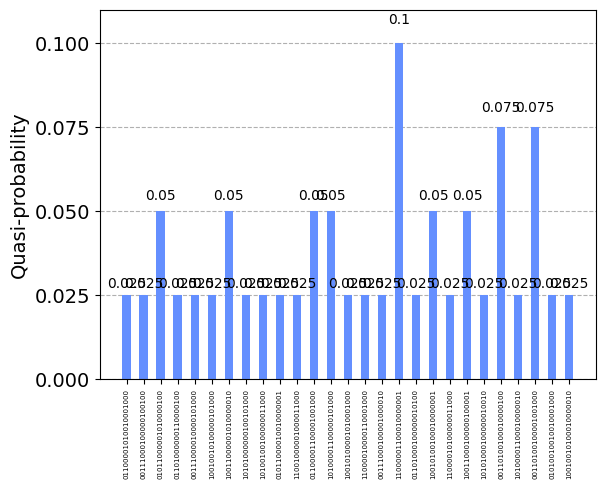

In [58]:
# plot QUBO solutions distributions
plot_solutions_distribution(samples)

## Graver Augmented Multiseed Algorithm

### Define decision variables

In [59]:
# use Gurobi and build the model by sequentially adding constraints
# After that we'll use gurobipy library to retrieve the constraint matrix

# Declare and initialize model
m = gp.Model('VRP_GAMA')

# Create edges variables
x = {}
for i in range(n):
  for j in range(n):
    if E[i,j]!=0 and i!=j:
      x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

# Create capacity variables
u = {}
for i in range(1, n):
  num_var_enc = int(np.ceil(np.log2(C-d[i]+1)))    # u_i = d[i] + sum([2^j * u[i,j] for j in range(num_var_enc-1)]) + (C-sum([2^j for j in range(num_var_enc-1)]))*u[i,num_var_enc]
  for j in range(num_var_enc):
    u[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"u[{i},{j}]")

# Create slack variables for CCCs
s = {}
for i in range(1, n):
  for j in range(1, n):
    if E[i,j]!=0 and i!=j and d[i]+d[j]<=C:
      num_var_enc = int(np.ceil(np.log2(3*C-d[i]-d[j]+1)))   # s_ij = -C + sum([2^t * s[i,j,t] for t in range(num_var_enc-1)])+ (2C-d[i]-d[j]-sum([2^j for j in range(num_var_enc-1)]))*s[i,j,num_var_enc]
      for t in range(num_var_enc):
        s[(i,j,t)] = m.addVar(vtype=GRB.BINARY, name=f"s[{i},{j},{t}]")

m.update()

### Define constraints

In [60]:
# k vehicle departing from depot
m.addConstr(sum(x[(0, j)] for j in range(1, n) if E[0, j]!=0) == k, name='leave_depot')

# k vehicle returning to depot
m.addConstr(sum(x[(j, 0)] for j in range(1, n) if E[j, 0]!=0) == k, name='return_depot')

# only one vehicle on edge (i, j) for every (i, j)
m.addConstrs((sum(x[(i, j)] for i in range(n) if E[i, j]!=0 and i!=j) == 1 for j in range(1, n)), name='enter_node')
m.addConstrs((sum(x[(i, j)] for j in range(n) if E[i, j]!=0 and i!=j) == 1 for i in range(1, n)), name='leave_node')

# Capacity Cut Constraints with slack variables and logarithmic binary encoding
m.addConstrs((((d[i] + sum([2**t * u[(i,t)] for t in range(int(np.ceil(np.log2(C-d[i]+1)))-1)]) +
                (C-sum([2**t for t in range(int(np.ceil(np.log2(C-d[i]+1)))-1)])-d[i])
                *u[(i,int(np.ceil(np.log2(C-d[i]+1)))-1)])    # u[i]
               -(d[j] + sum([2**t * u[(j,t)] for t in range(int(np.ceil(np.log2(C-d[j]+1)))-1)]) +
                 (C-sum([2**t for t in range(int(np.ceil(np.log2(C-d[j]+1)))-1)])-d[j])*
                 u[(j,int(np.ceil(np.log2(C-d[j]+1)))-1)])    # u[j]
               +C*x[(i,j)]
               + (-C + sum([(2**t)*s[(i,j,t)] for t in range(int(np.ceil(np.log2(3*C-d[i]-d[j]+1)))-1)]) +
                  ((3*C-d[i]-d[j]-sum([2**t for t in range(int(np.ceil(np.log2(3*C-d[i]-d[j]+1)))-1)]))*
                   s[(i,j,int(np.ceil(np.log2(3*C-d[i]-d[j]+1)))-1)]))    # s[i,j] slack variable
               == C-d[j]) for i in range(1, n) for j in range(1, n)
               if E[i,j]!=0 and i!=j and d[i]+d[j]<=C), name='CCCs')

m.update()

### Define objective

In [61]:
# Define objective: minimize total cost of all assignments
obj = np.sum([E[i,j]*x[i,j]
              for i in range(n)
              for j in range(n) if E[i,j]!=0 and i!=j])

m.setObjective(obj, GRB.MINIMIZE)

m.update()

### Optimize the model via Gurobi

In [62]:
# Save model for inspection
m.write('VRP_GAMA.lp')
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 22 rows, 80 columns and 172 nonzeros
Model fingerprint: 0xd8925d2d
Variable types: 0 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Presolve removed 12 rows and 60 columns
Presolve time: 0.00s
Presolved: 10 rows, 20 columns, 40 nonzeros
Variable types: 0 continuous, 20 integer (20 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: cutoff, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        52.00000   52.00000  0

In [63]:
# get non zero decision variables (only x's)
routes = []
for v in m.getVars():
  if v.varName[0]=='x' and v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    routes.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_routing(routes)

(False, [[0, 2, 0], [0, 3, 0]])

### Retrieve constraint matrix

In [64]:
# Get the constraint matrix A and vector b (Ax=b) from Gurobi model
m.update()
# x = m.getVars()
A = m.getA()
A = A.toarray()
b = np.array(m.getAttr("RHS", m.getConstrs()), int)
obj_coeffs = m.getAttr("Obj", m.getVars())

# create decision variables
x = Array.create('x', shape=(A.shape[1]), vartype='BINARY')

In [65]:
# Objective function definition
def f(x):
  return np.sum([obj_coeffs[i]*x[i] for i in range(len(obj_coeffs))])

# Constraints satisfaction
def const(x):
    return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

In [66]:
# con = []
# for c in m.getConstrs():
#   if c.ConstrName == "leave_node[4]":
#     con.append(c)

# con = con[0]

# print(f"{m.getRow(con)} {con.Sense} {con.RHS}")

In [67]:
# # check gurobi solution
# var = np.array([v.x for v in m.getVars()])
# print(np.dot(A,var)-b) # feasibility
# print(np.dot(obj_coeffs, var)) # obj value

### Graver Augmentation

In [68]:
# compute graver basis elements
graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
print(len(graver_elems), ' graver elements found.')

40  graver elements found.


In [69]:
# compute feasible solutions
feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
print(len(feas_sols), ' feasible solutions found.')

4  feasible solutions found.


In [70]:
# Multiseed Augmentation
final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

# get best solution
x_opt = final_sols[np.argmin(final_obj_full), :]
print(x_opt, np.min(final_obj_full))

[1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 1. 0. 0. 1. 0. 0. 1.] 58.0


In [71]:
edges = []
for i in range(n):
  for j in range(n):
    if E[i,j]!=0 and i!=j:
      edges.append((i,j))

edges = [edges[i] for i in range(len(edges)) if x_opt[i]>1e-6]

print(edges)

is_valid_routing(edges, VERBOSE=True)

[(0, 1), (0, 3), (1, 4), (2, 0), (3, 0), (4, 2)]
Valid routing. The routes are

[0, 1, 4, 2, 0]
[0, 3, 0]


(True, [[0, 1, 4, 2, 0], [0, 3, 0]])

# 2-Phase Heuristic: Clustering (Multi-Knapsack Problem)

## Formulation

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{v} \sum_{(i, j)\in E} c_{ij}z_{v,i}z_{v,j} \\
\text{subject to} \quad & \sum_{v = 0}^{k-1} z_{v,0} = k \\
& \sum_{v = 0}^{k-1} z_{v,i} = 1 \quad \forall i=1, \dots, n-1 \\
& \sum_{i = 1}^{n-1} d_iz_{v,i} \leq C \quad \forall v=0, \dots, k-1 \\
& z_{v,i} \in \{0, 1\} \quad \forall v=0, \dots, k-1; \,\, i=0, \dots, n-1
\end{alignat*}

## Gurobi

In [72]:
# Declare and initialize model
m = gp.Model('MKP')

### Decision variables

In [73]:
# Create decision variables

# edge variables
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = m.addVar(vtype=GRB.BINARY, name=f"z[{v},{i}]")

# update model
m.update()

### Constraints

In [74]:
# the depot must be in each cluster
m.addConstr(sum(z[(v, 0)] for v in range(k)) == k, name='depot_in_every_cluster')

# each object in exactly one knapsack (each customer served by exactly one vehicle)
m.addConstrs((sum(z[(v, i)] for v in range(k)) == 1 for i in range(1, n)), name='each_customer_to_one_vehicle')

# the total demands of customer served by vehicle v cannot exceed the vehicle capacity
m.addConstrs((sum(d[i]*z[(v, i)] for i in range(1, n)) <= C for v in range(k)), name='vehicle_capacity')

# update model
m.update()

### Objective function

In [75]:
# Objective: minimize total cost of all assignments
obj = np.sum([E[i,j]*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)
              if i!=j and E[i,j]!=0])

m.setObjective(obj, GRB.MINIMIZE)

# update model
m.update()

### Optimize

In [76]:
# Save model for inspection
m.write('MKP.lp')

# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 10 columns and 18 nonzeros
Model fingerprint: 0x1c38785c
Model has 20 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 218.0000000
Presolve removed 7 rows and 6 columns
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 9 nonzeros
Variable types: 0 continuous, 7 integer (7 binary)
Found heuristic solution: objective 126.0000000

Root relaxation: objective 1.140000e+02, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

In [77]:
# get customers
clusters = []
for v in m.getVars():
  if v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    clusters.append((int(nodes_indices[0]), int(nodes_indices[1])))

gurobi_clusters = is_valid_clustering(clusters)
print(gurobi_clusters)
gurobi_clusters = gurobi_clusters[1]

(True, [[0, 2, 3], [0, 1, 4]])


## QUBO

### Define the variables

In [78]:
# create QUBO variables for the edges
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = Binary(f'z[{v},{i}]')

# create slack variables for capacity constraints
# Normally the slack variables would be integer, so we need to binary encode them.
# As usual, we use logarithmic encoding to reduce the number of variables
s = {}
for v in range(k):
  s[v] = LogEncInteger(f's[{v}]', (C-int(sum(d[1:])), C))

# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

### Build the matrix

In [79]:
# build QUBO by manually adding objective and constraints

# define objective function
obj = sum([E[i,j]*z[(v,i)]*z[(v,j)]
          for i in range(n)
          for j in range(n)
          for v in range(k)
          if i!=j and E[i,j]!=0])

# add the objective
Q =  obj

# add the constraints
# depot assigned to each cluster
Q += p*(Constraint((sum([z[(v, 0)] for v in range(k)])-k)**2, label=f'depot_in_every_cluster'))

# each customer assigned to exactly one vehicle
Q += p*sum([Constraint((sum([z[(v, i)] for v in range(k)])-1)**2, label=f'assign_node_{i}') for i in range(1, n)])

# Capacity Constraints
Q += p*sum([Constraint((sum([d[i]*z[(v,i)] for i in range(1, n)]) + s[v] - C)**2,
                       label=f'capacity({v})') for v in range(k)])

In [80]:
# get QUBO matrix
model = Q.compile()
Q, offset = model.to_qubo()
Q

{('z[1,4]', 'z[1,4]'): -1752.0,
 ('s[0][1]', 'z[0,3]'): 876.0,
 ('s[0][2]', 'z[0,4]'): 438.0,
 ('z[1,2]', 'z[1,0]'): 22.0,
 ('s[1][2]', 's[1][2]'): -1533.0,
 ('z[0,1]', 'z[0,1]'): -1752.0,
 ('z[1,3]', 'z[1,1]'): 468.0,
 ('z[1,3]', 'z[1,0]'): 16.0,
 ('s[1][0]', 'z[1,1]'): 438.0,
 ('s[1][1]', 'z[1,4]'): 876.0,
 ('z[0,1]', 'z[0,0]'): 30.0,
 ('s[0][1]', 'z[0,2]'): 876.0,
 ('s[1][2]', 's[1][1]'): 876.0,
 ('z[0,4]', 'z[0,2]'): 456.0,
 ('z[1,0]', 'z[0,0]'): 438.0,
 ('s[0][0]', 'z[0,1]'): 438.0,
 ('s[1][1]', 'z[1,3]'): 876.0,
 ('s[1][0]', 'z[1,3]'): 438.0,
 ('s[0][2]', 'z[0,2]'): 438.0,
 ('s[0][0]', 's[0][0]'): -1533.0,
 ('s[0][2]', 'z[0,3]'): 438.0,
 ('z[1,4]', 'z[1,0]'): 10.0,
 ('z[0,0]', 'z[0,0]'): -657.0,
 ('z[0,3]', 'z[0,0]'): 16.0,
 ('s[1][1]', 'z[1,2]'): 876.0,
 ('s[0][0]', 'z[0,3]'): 438.0,
 ('z[0,2]', 'z[0,2]'): -1752.0,
 ('z[1,1]', 'z[1,1]'): -1752.0,
 ('s[1][0]', 'z[1,2]'): 438.0,
 ('s[1][1]', 's[1][0]'): 876.0,
 ('s[0][2]', 's[0][0]'): 438.0,
 ('z[0,3]', 'z[0,1]'): 468.0,
 ('s[1][2

### Solve QUBO via Quantum Annealing

In [81]:
# solve the model with the chosen sampler
if solver=='SimulAnneal':   # classic solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, num_steps=1000)
elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
  sampleset = sampler.sample_qubo(Q)
elif solver=='Advantage_system6.2':   # quantum solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])

# get obtained solutions
samples = model.decode_sampleset(sampleset)

# take only valid solutions (actual clusterings)
samples = [s for s in samples if is_valid_clustering(get_clusters_from_sample(s.sample))[0]==True]

best_sample, energy = None, None

if len(samples)>0:
  # take only best solution (minimum energy)
  best_sample = min(samples, key=lambda s: s.energy)
  print(best_sample.sample, '\n', best_sample.energy)

{'z[1,4]': 1, 'z[1,3]': 0, 'z[1,2]': 0, 's[0][1]': 1, 'z[0,3]': 1, 's[0][2]': 0, 's[1][0]': 0, 's[1][1]': 1, 's[1][2]': 0, 'z[0,1]': 0, 's[0][0]': 0, 'z[0,2]': 1, 'z[0,4]': 0, 'z[1,0]': 1, 'z[0,0]': 1, 'z[1,1]': 1} 
 114.0


In [82]:
# compute original objective function value in best_sample
z = {}

if best_sample != None:
  for v in range(k):
    for i in range(n):
      z[(v, i)] = best_sample.sample[f'z[{v},{i}]']

  # original objective function value
  obj = np.sum([E[i,j]*z[(v,i)]*z[(v,j)]
              for i in range(n)
              for j in range(n)
              for v in range(k)])
  print(obj)

114


In [83]:
# check if solution is a valid clustering
annealing_clusters = is_valid_clustering(get_clusters_from_sample(best_sample.sample))
print(annealing_clusters)
annealing_clusters = annealing_clusters[1]

(True, [[0, 2, 3], [0, 1, 4]])


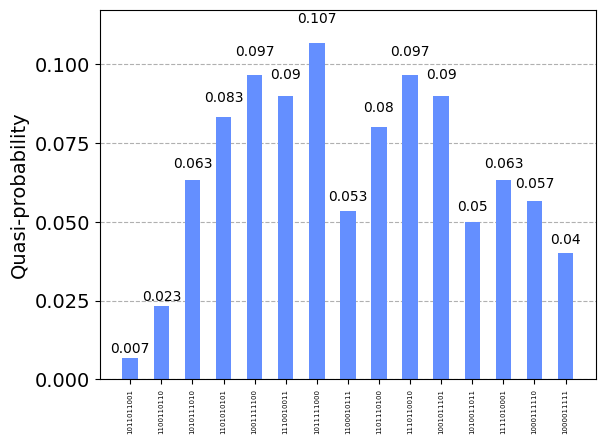

In [84]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution(samples, problem='clustering')

### Solve QUBO via Numpy Exact Solver

In [85]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q)

# Numpy Exact Solver
numpy_solver = NumPyMinimumEigensolver()
optimizer = MinimumEigenOptimizer(numpy_solver)
result = optimizer.solve(qp)
ref_value = result.fval
print('optimal objective value: ', ref_value, '\n', 'optimal solution: ', result.x)

optimal objective value:  114.0 
 optimal solution:  [1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0.]


In [86]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

is_valid_clustering(clusters)

(True, [[0, 2, 3], [4, 1, 0]])

### Solve QUBO via VQE

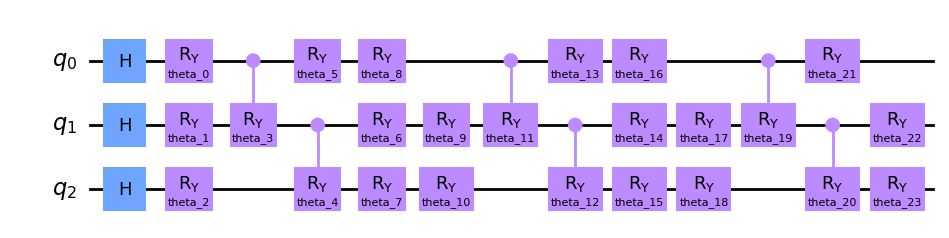

In [87]:
def build_ansatz_circuit(num_qubits, num_layers):

  # instantiate the circuit
  qc = QuantumCircuit(num_qubits)
  theta_idx = 0  # Initialize theta_idx to zero

  # Step 1: Apply Hadamard gates to all qubits
  qc.h(range(num_qubits))

  # Step 2, 3, and 4: Apply RY rotations and linear entanglement in each layer
  for layer in range(num_layers):
    # Apply RY rotations to each qubit in the current layer
    for qubit in range(num_qubits):
        theta = Parameter(f'theta_{theta_idx}')
        qc.ry(theta, qubit)
        theta_idx += 1  # Increment theta_idx

    # Apply linear entanglement using Controlled-RY gates in the current layer
    for qubit in range(num_qubits - 1):
        control_qubit = qubit
        target_qubit = qubit + 1
        theta = Parameter(f'theta_{theta_idx}')
        qc.cry(theta, control_qubit, target_qubit)
        theta_idx += 1  # Increment theta_idx

    # Apply RY rotations to each qubit again in the current layer
    for qubit in range(num_qubits):
        theta = Parameter(f'theta_{theta_idx}')
        qc.ry(theta, qubit)
        theta_idx += 1  # Increment theta_idx

  return qc

ansatz_circuit = build_ansatz_circuit(3, 3)

ansatz_circuit.draw(output='mpl')

In [88]:
classic_optimizer = [ADAM, AQGD, CG, COBYLA, L_BFGS_B,
                     GradientDescent, NELDER_MEAD, NFT, P_BFGS, POWELL,
                     SLSQP, SPSA, QNSPSA, TNC, SciPyOptimizer, UMDA]

In [89]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q)

# print Quadratic Program
print(qp.prettyprint())

# Choose the classical optimizer
classic_optimizer = classic_optimizer[11](maxiter=125)

max_depth = 3
circuit_depth = 0

while circuit_depth < max_depth:

  # increase circuit depth
  circuit_depth += 1
  print('current circuit depth: ', circuit_depth)

  # Lists used in callback function to print the optimization progress
  counts_callback, values_callback = [], []
  # reset callback
  best_params = None
  best_evaluation = float('inf')

  # Define VQE ansatz
  # ansatz = RealAmplitudes(len(qp.variables), entanglement='full', reps=circuit_depth)  # Adjust the number of repetitions (p) as needed
  ansatz = build_ansatz_circuit(len(qp.variables), num_layers=circuit_depth)  # Adjust the number of layers as needed

  if circuit_depth==1:
    initial_point = np.random.uniform(low=-2*np.pi, high=2*np.pi, size=ansatz.num_parameters)

  # Run VQE optimization
  vqe = SamplingVQE(qiskit_sampler, ansatz=ansatz, optimizer=classic_optimizer, callback=store_intermediate_result, initial_point=initial_point)
  optimizer = MinimumEigenOptimizer(vqe)
  result = optimizer.solve(qp)

  # define new set of parameters
  # new_params = list(np.random.uniform(low=-2*np.pi, high=2*np.pi, size=2*len(qp.variables) + len(qp.variables)-1))
  new_params = list(np.random.choice(a=best_params, size=2*len(qp.variables) + len(qp.variables)-1))

  # print(len(best_params), len(new_params))

  # define new set of initial parameters
  initial_point = best_params + new_params

print('optimal objective value: ', result.fval.real, '\n', 'optimal solution: ', result.x)
print(f"Final Energy: {result.fval.real:.5f}")
print(f"Delta from reference energy value is {(result.fval.real - ref_value):.5f}")

Problem name: 

Minimize
  876*s[0][0]*s[0][1] + 438*s[0][0]*s[0][2] + 438*s[0][0]*z[0,2]
  + 438*s[0][0]*z[0,3] + 438*s[0][0]*z[0,4] + 876*s[0][1]*s[0][2]
  + 876*s[0][1]*z[0,3] + 876*s[0][1]*z[0,4] + 438*s[1][0]*z[1,2]
  + 876*s[1][1]*s[1][0] + 876*s[1][1]*z[1,2] + 876*s[1][1]*z[1,3]
  + 438*s[1][2]*s[1][0] + 876*s[1][2]*s[1][1] + 438*s[1][2]*z[1,1]
  + 438*s[1][2]*z[1,2] + 438*s[1][2]*z[1,3] + 22*z[0,0]*z[0,2]
  + 16*z[0,0]*z[0,3] + 10*z[0,0]*z[0,4] + 438*z[0,0]*z[1,0] + 438*z[0,1]*s[0][0]
  + 876*z[0,1]*s[0][1] + 438*z[0,1]*s[0][2] + 30*z[0,1]*z[0,0]
  + 472*z[0,1]*z[0,2] + 468*z[0,1]*z[0,3] + 452*z[0,1]*z[0,4]
  + 438*z[0,1]*z[1,1] + 876*z[0,2]*s[0][1] + 438*z[0,2]*s[0][2]
  + 460*z[0,2]*z[0,3] + 456*z[0,2]*z[0,4] + 438*z[0,2]*z[1,2]
  + 438*z[0,3]*s[0][2] + 438*z[0,4]*s[0][2] + 460*z[0,4]*z[0,3]
  + 22*z[1,0]*z[1,2] + 438*z[1,1]*s[1][0] + 876*z[1,1]*s[1][1]
  + 30*z[1,1]*z[1,0] + 472*z[1,1]*z[1,2] + 468*z[1,1]*z[1,3]
  + 438*z[1,3]*s[1][0] + 438*z[1,3]*z[0,3] + 16*z[1,3]*z[1,0]
 

In [90]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

vqe_clusters = is_valid_clustering(clusters)
print(vqe_clusters)
vqe_clusters = vqe_clusters[1]

(True, [[1, 0, 4], [3, 0, 2]])


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Convergence')

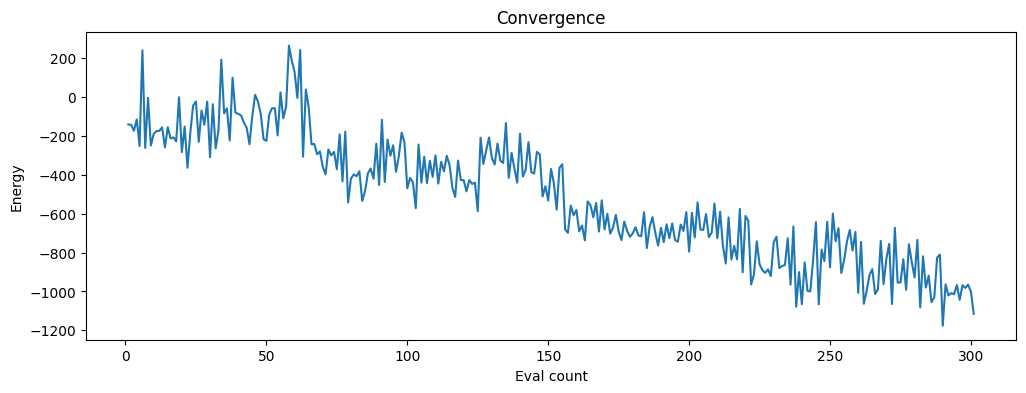

In [91]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_callback, values_callback)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence")

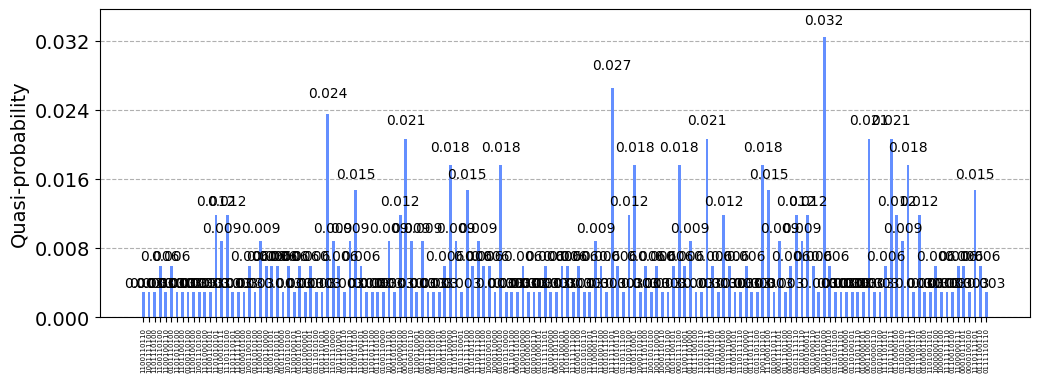

In [92]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution_VQA(qp, result, problem='clustering')

In [93]:
# # print the Ansatz (smaller version for better visualization)
# ansatz = RealAmplitudes(3, entanglement='full', reps=2)
# ansatz.decompose().draw(output='mpl')

In [94]:
# samples = []
# probabilities = []
# fval = []
# for s in result.samples:
#   x = ''
#   for v in range(k):
#     for i in range(n):
#       x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))
#   samples.append(x)
#   probabilities.append(s.probability)
#   fval.append(s.fval)

# sum([probabilities[i] for i in range(len(samples)) if fval[i]==237.0])

### Solve QUBO via QAOA

In [95]:
# ################################ WARM-START QAOA ###############################

# # Retrieve Quadratic Program from QUBO
# qp = QUBO_to_QuadProg(Q)

# # print Quadratic Program
# print(qp.prettyprint())

# # Choose the classical optimizer
# classic_optimizer = SPSA(maxiter=125)

# # define the depth of the circuit
# circuit_depth = 1

# # Lists used in callback function to print the optimization progress
# counts_callback, values_callback = [], []
# # reset callback
# best_params = None
# best_evaluation = float('inf')

# # Run Warm-Start QAOA using Cobyla to presolve continuous relaxation of QUBO
# qaoa_mes = QAOA(qiskit_sampler, reps=circuit_depth, optimizer=classic_optimizer, callback=store_intermediate_result)
# ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CobylaOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes, epsilon=0.0)
# ws_result = ws_qaoa.solve(qp)
# print(ws_result.prettyprint())

In [96]:
classic_optimizer = [ADAM, AQGD, CG, COBYLA, L_BFGS_B,
                     GradientDescent, NELDER_MEAD, NFT, P_BFGS, POWELL,
                     SLSQP, SPSA, QNSPSA, TNC, SciPyOptimizer, UMDA]

In [97]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q)

# print Quadratic Program
print(qp.prettyprint())

# Choose the classical optimizer
classic_optimizer = classic_optimizer[11](maxiter=125)

max_depth = 1
circuit_depth = 0

while circuit_depth < max_depth:

  # increase circuit depth
  circuit_depth += 1
  print('current circuit depth: ', circuit_depth)

  # Lists used in callback function to print the optimization progress
  counts_callback, values_callback = [], []
  # reset callback
  best_params = None
  best_evaluation = float('inf')

  if circuit_depth==1:
    initial_point = np.random.uniform(low=0, high=2*np.pi, size=2)

  # Run QAOA optimization
  qaoa = QAOA(qiskit_sampler, reps=circuit_depth, optimizer=classic_optimizer, callback=store_intermediate_result, initial_point=initial_point)
  optimizer = MinimumEigenOptimizer(qaoa)
  result = optimizer.solve(qp)

  # get gamma parameters
  gamma = best_params[::2]
  gamma.insert(0, 0)
  gamma.append(0)

  # get beta parameters
  beta = best_params[1::2]
  beta.insert(0, 0)
  beta.append(0)

  # define new gamma parameters by linearly interpolating previous gamma
  new_gamma = []
  for i in range(1, circuit_depth+2):
    new_gamma.append((i-1)/circuit_depth*gamma[i-1] + (circuit_depth-i+1)/circuit_depth*gamma[i])

  # define new beta parameters by linearly interpolating previous gamma
  new_beta = []
  for i in range(1, circuit_depth+2):
    new_beta.append((i-1)/circuit_depth*beta[i-1] + (circuit_depth-i+1)/circuit_depth*beta[i])

  initial_point = []
  for i in range(len(new_gamma)):
    initial_point.append(new_gamma[i])
    initial_point.append(new_beta[i])

print('optimal objective value: ', result.fval.real, '\n', 'optimal solution: ', result.x)
print(f"Final Energy: {result.fval.real:.5f}")
print(f"Delta from reference energy value is {(result.fval.real - ref_value):.5f}")

Problem name: 

Minimize
  876*s[0][0]*s[0][1] + 438*s[0][0]*s[0][2] + 438*s[0][0]*z[0,2]
  + 438*s[0][0]*z[0,3] + 438*s[0][0]*z[0,4] + 876*s[0][1]*s[0][2]
  + 876*s[0][1]*z[0,3] + 876*s[0][1]*z[0,4] + 438*s[1][0]*z[1,2]
  + 876*s[1][1]*s[1][0] + 876*s[1][1]*z[1,2] + 876*s[1][1]*z[1,3]
  + 438*s[1][2]*s[1][0] + 876*s[1][2]*s[1][1] + 438*s[1][2]*z[1,1]
  + 438*s[1][2]*z[1,2] + 438*s[1][2]*z[1,3] + 22*z[0,0]*z[0,2]
  + 16*z[0,0]*z[0,3] + 10*z[0,0]*z[0,4] + 438*z[0,0]*z[1,0] + 438*z[0,1]*s[0][0]
  + 876*z[0,1]*s[0][1] + 438*z[0,1]*s[0][2] + 30*z[0,1]*z[0,0]
  + 472*z[0,1]*z[0,2] + 468*z[0,1]*z[0,3] + 452*z[0,1]*z[0,4]
  + 438*z[0,1]*z[1,1] + 876*z[0,2]*s[0][1] + 438*z[0,2]*s[0][2]
  + 460*z[0,2]*z[0,3] + 456*z[0,2]*z[0,4] + 438*z[0,2]*z[1,2]
  + 438*z[0,3]*s[0][2] + 438*z[0,4]*s[0][2] + 460*z[0,4]*z[0,3]
  + 22*z[1,0]*z[1,2] + 438*z[1,1]*s[1][0] + 876*z[1,1]*s[1][1]
  + 30*z[1,1]*z[1,0] + 472*z[1,1]*z[1,2] + 468*z[1,1]*z[1,3]
  + 438*z[1,3]*s[1][0] + 438*z[1,3]*z[0,3] + 16*z[1,3]*z[1,0]
 

In [98]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

qaoa_clusters = is_valid_clustering(clusters)
print(qaoa_clusters)
qaoa_clusters = qaoa_clusters[1]

(True, [[1, 0, 2], [4, 3, 0]])


Text(0.5, 1.0, 'Convergence')

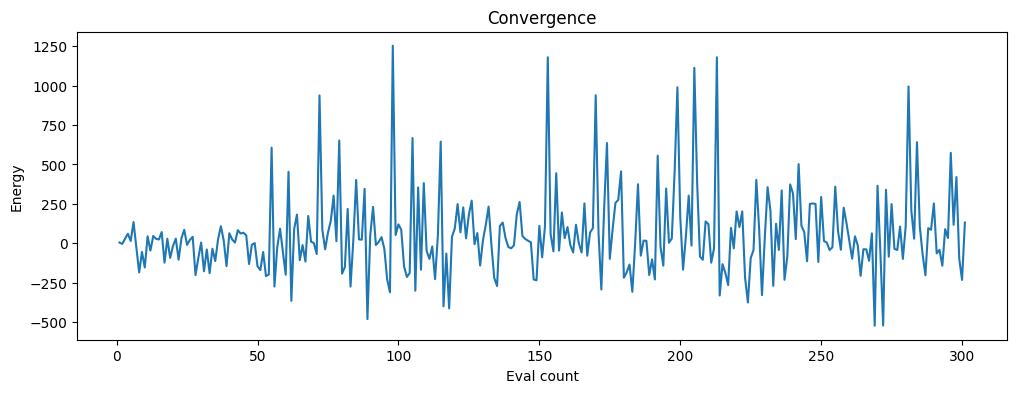

In [99]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_callback, values_callback)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence")

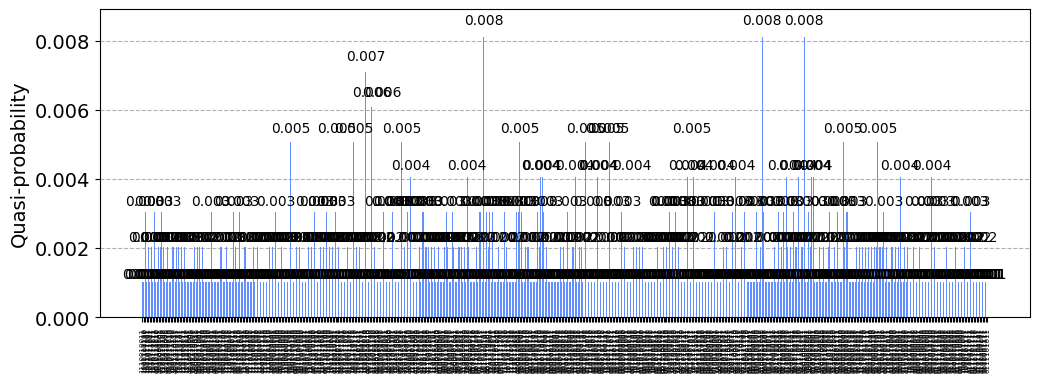

In [100]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution_VQA(qp, result, problem='clustering')

In [101]:
# samples = []
# probabilities = []
# fval = []
# for s in result.samples:
#   x = ''
#   for v in range(k):
#     for i in range(n):
#       x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))
#   samples.append(x)
#   probabilities.append(s.probability)
#   fval.append(s.fval)

# sum([probabilities[i] for i in range(len(samples)) if fval[i]==74.0])

### Solve QUBO via QAOA (warm-start via Louvein communities)

In [102]:
louvain_clusters

[[0, 1, 2, 3, 4]]

In [103]:
# set z variables (assignment vehicle-node)
z = np.zeros((k,n))
for v in range(len(louvain_clusters)):
  for node in louvain_clusters[v]:
    z[v, node] = 1

# set slack variables for capacity constraints
num_var_enc = int(np.ceil(np.log2(int(sum(d[1:]))+1)))    # number of bits in the logarithmic encoding
coeffs = [2**t for t in range(num_var_enc-1)]   # coefficients of the logarithmic encoding
coeffs.append((int(sum(d[1:]))-sum([2**t for t in range(num_var_enc-1)])))    # last coefficient of the logarithmic encoding
s = np.zeros((k, num_var_enc))    # initialize all the bits to zero, for each slack variable
for v in range(k):
  value = C - sum([d[i]*z[v,i] for i in range(n)])    # value of the slack variable in the Louvain solution
  S = C - int(sum(d[1:]))   # starting value for the logarithmic encoding
  for t in range(num_var_enc):
    S += coeffs[t]*2**t   # we are counting how many bits need to be set to 1 for the slack variable to reach the achieved value in the Louvain solution
    s[v, t] = 1
    if S>=value:
      break   # if we reached the slack variable value then break the cycle. The remaining bits must remain set to zero

In [104]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q)

# print Quadratic Program
print(qp.prettyprint())

# build feasible solution associated to Louvain clusterization
c_stars = []
for i in range(len(qp.variables)):
  name = qp.variables[i].name
  # print(name)
  vars = re.findall(r'\d+', name)
  vars = [int(var) for var in vars]
  if name[0]=='z':
    c_stars.append(z[vars[0], vars[1]])
    # print('set z')
  elif name[0]=='s':
    c_stars.append(s[vars[0], vars[1]])
    # print('set s')

print('c_stars = ', c_stars)

Problem name: 

Minimize
  876*s[0][0]*s[0][1] + 438*s[0][0]*s[0][2] + 438*s[0][0]*z[0,2]
  + 438*s[0][0]*z[0,3] + 438*s[0][0]*z[0,4] + 876*s[0][1]*s[0][2]
  + 876*s[0][1]*z[0,3] + 876*s[0][1]*z[0,4] + 438*s[1][0]*z[1,2]
  + 876*s[1][1]*s[1][0] + 876*s[1][1]*z[1,2] + 876*s[1][1]*z[1,3]
  + 438*s[1][2]*s[1][0] + 876*s[1][2]*s[1][1] + 438*s[1][2]*z[1,1]
  + 438*s[1][2]*z[1,2] + 438*s[1][2]*z[1,3] + 22*z[0,0]*z[0,2]
  + 16*z[0,0]*z[0,3] + 10*z[0,0]*z[0,4] + 438*z[0,0]*z[1,0] + 438*z[0,1]*s[0][0]
  + 876*z[0,1]*s[0][1] + 438*z[0,1]*s[0][2] + 30*z[0,1]*z[0,0]
  + 472*z[0,1]*z[0,2] + 468*z[0,1]*z[0,3] + 452*z[0,1]*z[0,4]
  + 438*z[0,1]*z[1,1] + 876*z[0,2]*s[0][1] + 438*z[0,2]*s[0][2]
  + 460*z[0,2]*z[0,3] + 456*z[0,2]*z[0,4] + 438*z[0,2]*z[1,2]
  + 438*z[0,3]*s[0][2] + 438*z[0,4]*s[0][2] + 460*z[0,4]*z[0,3]
  + 22*z[1,0]*z[1,2] + 438*z[1,1]*s[1][0] + 876*z[1,1]*s[1][1]
  + 30*z[1,1]*z[1,0] + 472*z[1,1]*z[1,2] + 468*z[1,1]*z[1,3]
  + 438*z[1,3]*s[1][0] + 438*z[1,3]*z[0,3] + 16*z[1,3]*z[1,0]
 

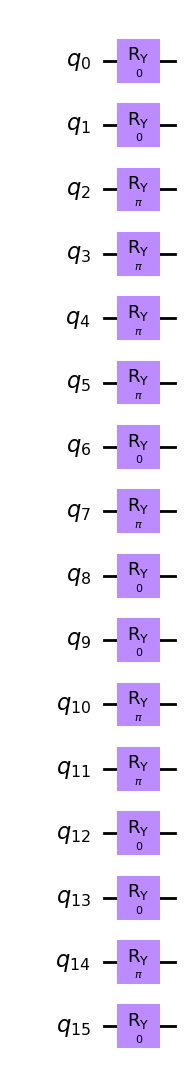

In [105]:
# build the initial point starting from c_stars
thetas = [2 * np.arcsin(np.sqrt(c_star)) for c_star in c_stars]
init_qc = QuantumCircuit(len(c_stars))
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)

init_qc.draw(output="mpl")

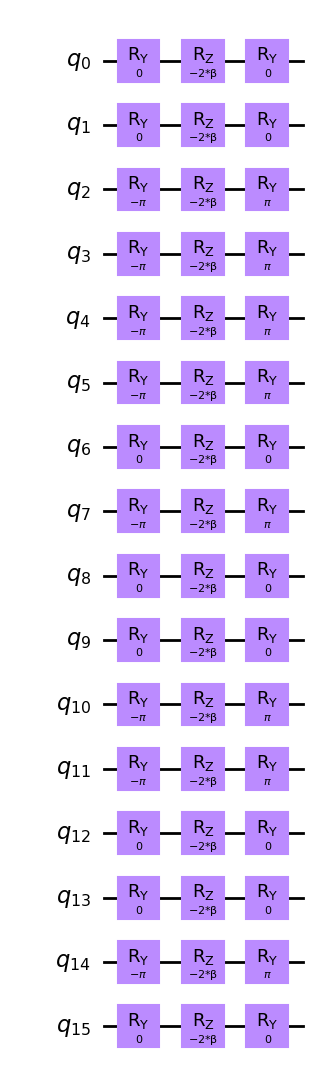

In [106]:
# build the mixer Hamiltonian
beta = Parameter("β")
ws_mixer = QuantumCircuit(len(c_stars))
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2 * beta, idx)
    ws_mixer.ry(theta, idx)

ws_mixer.draw(output="mpl")

In [107]:
classic_optimizer = [ADAM, AQGD, CG, COBYLA, L_BFGS_B,
                     GradientDescent, NELDER_MEAD, NFT, P_BFGS, POWELL,
                     SLSQP, SPSA, QNSPSA, TNC, SciPyOptimizer, UMDA]

# Choose the classical optimizer
classic_optimizer = classic_optimizer[11](maxiter=125)

max_depth = 1
circuit_depth = 0

while circuit_depth < max_depth:

  # increase circuit depth
  circuit_depth += 1
  print('current circuit depth: ', circuit_depth)

  # Lists used in callback function to print the optimization progress
  counts_callback, values_callback = [], []
  # reset callback
  best_params = None
  best_evaluation = float('inf')

  if circuit_depth==1:
    initial_point = np.random.uniform(low=0, high=2*np.pi, size=2)

  # Run QAOA optimization
  qaoa = QAOA(sampler = Sampler(),    # if you change the sampler this might not work... Still don't know why...
              reps=circuit_depth,
              optimizer=classic_optimizer,
              initial_state=init_qc,
              mixer=ws_mixer,
              initial_point=initial_point,
              callback=store_intermediate_result)
  optimizer = MinimumEigenOptimizer(qaoa)
  result = optimizer.solve(qp)

  # get gamma parameters
  gamma = best_params[::2]
  gamma.insert(0, 0)
  gamma.append(0)

  # get beta parameters
  beta = best_params[1::2]
  beta.insert(0, 0)
  beta.append(0)

  # define new gamma parameters by linearly interpolating previous gamma
  new_gamma = []
  for i in range(1, circuit_depth+2):
    new_gamma.append((i-1)/circuit_depth*gamma[i-1] + (circuit_depth-i+1)/circuit_depth*gamma[i])

  # define new beta parameters by linearly interpolating previous gamma
  new_beta = []
  for i in range(1, circuit_depth+2):
    new_beta.append((i-1)/circuit_depth*beta[i-1] + (circuit_depth-i+1)/circuit_depth*beta[i])

  initial_point = []
  for i in range(len(new_gamma)):
    initial_point.append(new_gamma[i])
    initial_point.append(new_beta[i])

print('optimal objective value: ', result.fval.real, '\n', 'optimal solution: ', result.x)
print(f"Final Energy: {result.fval.real:.5f}")
print(f"Delta from reference energy value is {(result.fval.real - ref_value):.5f}")

current circuit depth:  1
optimal objective value:  875.0 
 optimal solution:  [0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0.]
Final Energy: 875.00000
Delta from reference energy value is 761.00000


In [108]:
# ################################ WARM-START QAOA ###############################

# # Retrieve Quadratic Program from QUBO
# qp = QUBO_to_QuadProg(Q)

# # print Quadratic Program
# print(qp.prettyprint())

# # Choose the classical optimizer
# classic_optimizer = SPSA(maxiter=125)

# # define the depth of the circuit
# circuit_depth = 1

# # Lists used in callback function to print the optimization progress
# counts_callback, values_callback = [], []
# # reset callback
# best_params = None
# best_evaluation = float('inf')

# # Run Warm-Start QAOA using Cobyla to presolve continuous relaxation of QUBO
# qaoa_mes = QAOA(qiskit_sampler, reps=circuit_depth, optimizer=classic_optimizer, callback=store_intermediate_result)
# ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CobylaOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes, epsilon=0.0)
# ws_result = ws_qaoa.solve(qp)
# print(ws_result.prettyprint())

In [109]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

wsqaoa_clusters = is_valid_clustering(clusters)
print(wsqaoa_clusters)
wsqaoa_clusters = wsqaoa_clusters[1]

(True, [[1, 0, 2, 4, 3]])


Text(0.5, 1.0, 'Convergence')

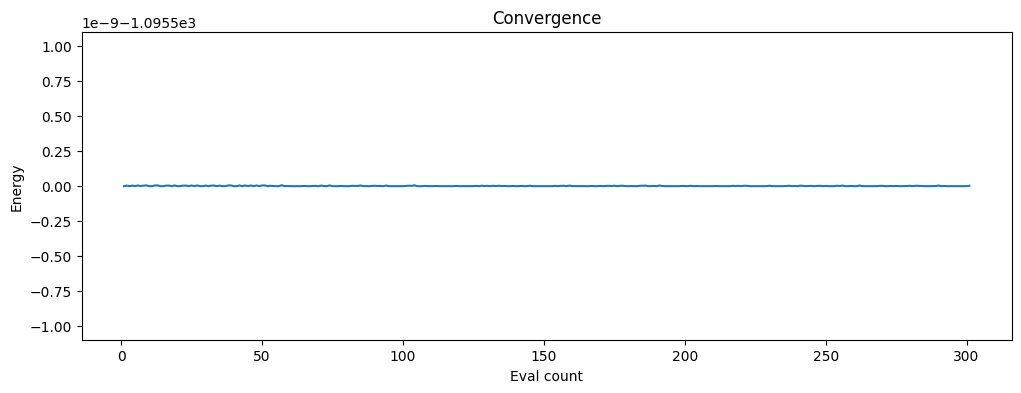

In [110]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_callback, values_callback)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence")

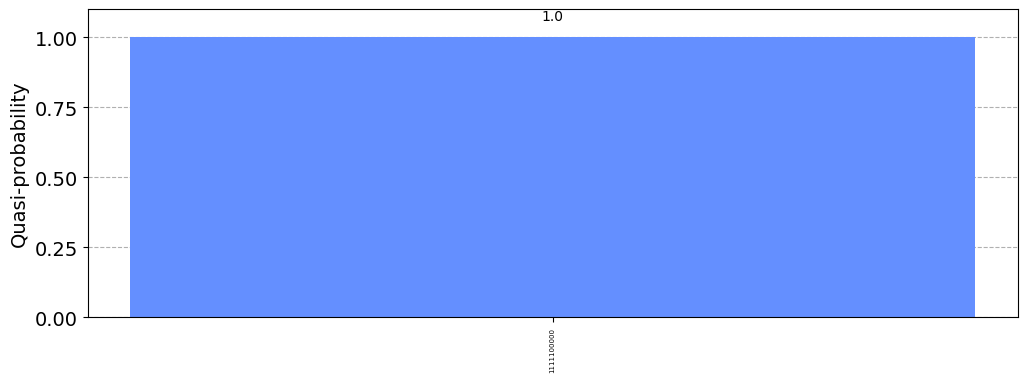

In [111]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution_VQA(qp, result, problem='clustering')

In [112]:
# samples = []
# probabilities = []
# fval = []
# for s in result.samples:
#   x = ''
#   for v in range(k):
#     for i in range(n):
#       x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))
#   samples.append(x)
#   probabilities.append(s.probability)
#   fval.append(s.fval)

# sum([probabilities[i] for i in range(len(samples)) if fval[i]==74.0])

## Graver Augmented Multiseed Algorithm

### Define decision variables

In [113]:
# use Gurobi and build the model by sequentially adding constraints
# After that we'll use gurobipy library to retrieve the constraint matrix

# Declare and initialize model
m = gp.Model('MKP_GAMA')

# Create edges variables
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = m.addVar(vtype=GRB.BINARY, name=f"z[{v},{i}]")

# Create slack variables for capacity constraints
s = {}
for v in range(k):
  num_var_enc = int(np.ceil(np.log2(int(sum(d[1:]))+1)))
  for t in range(num_var_enc):
    s[(v,t)] = m.addVar(vtype=GRB.BINARY, name=f"s[{v},{t}]")

m.update()

### Define constraints

In [114]:
# depot must be in each knapsack
m.addConstr(sum(z[(v, 0)] for v in range(k)) == k, name='each_customer_to_one_vehicle')

# each object in exactly one knapsack (each customer served by exactly one vehicle)
m.addConstrs((sum(z[(v, i)] for v in range(k)) == 1 for i in range(1, n)), name='each_customer_to_one_vehicle')

# the total demands of customer served by vehicle v cannot exceed the vehicle capacity
m.addConstrs((sum(d[i]*z[(v, i)] for i in range(1, n)) +
              (C - int(sum(d[1:])) + sum([2**t * s[(v,t)] for t in range(int(np.ceil(np.log2(int(sum(d[1:]))+1)))-1)]) +
              (int(sum(d[1:]))-sum([2**t for t in range(int(np.ceil(np.log2(int(sum(d[1:]))+1)))-1)]))
              *s[(v,int(np.ceil(np.log2(int(sum(d[1:]))+1)))-1)])   # s[v]
              == C for v in range(k)), name='vehicle_capacity')

# update model
m.update()

### Define objective

In [115]:
# Objective: minimize total cost of all assignments
obj = sum(E[i,j]*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)
              if i!=j and E[i,j]!=0)

m.setObjective(obj, GRB.MINIMIZE)

# update model
m.update()

### Optimize the model via Gurobi

In [116]:
# Save model for inspection
m.write('MKP_GAMA.lp')
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 16 columns and 24 nonzeros
Model fingerprint: 0x5c133496
Model has 20 quadratic objective terms
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 114.0000000
Presolve removed 7 rows and 12 columns
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 9 nonzeros
Variable types: 0 continuous, 7 integer (7 binary)

Explored 0 nodes (0 simplex iterations) in 0.17 seconds (0.00 work units)
Thread count was 2 (of 2 available processors)

Solution count 1: 114 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.1400000

In [117]:
# get non zero decision variables (only x's)
clusters = []
for v in m.getVars():
  if v.varName[0]=='z' and v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    clusters.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_clustering(clusters)

(True, [[0, 2, 3], [0, 1, 4]])

### Retrieve constraint matrix

In [118]:
# Get the constraint matrix A and vector b (Ax=b) from Gurobi model
m.update()
# x = m.getVars()
A = m.getA()
A = A.toarray()
b = np.array(m.getAttr("RHS", m.getConstrs()), int)

# create decision variables
num_var_enc = int(np.ceil(np.log2(int(sum(d[1:]))+1)))
x = Array.create('x', shape=(A.shape[1]), vartype='BINARY')

In [119]:
# Objective function definition
def f(x):
  y = x[:k*n, ]
  y = y.reshape((k, n))
  obj = sum(E[i,j]*y[v,i]*y[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)
              if i!=j and E[i,j]!=0)
  return obj

# Constraints satisfaction
def const(x):
    return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

In [120]:
# # check gurobi solution
# var = np.array([v.x for v in m.getVars()])
# print(np.dot(A,var)-b) # feasibility
# print(np.dot(obj_coeffs, var)) # obj value

### Graver Augmentation

In [121]:
# compute graver basis elements
graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
print(len(graver_elems), ' graver elements found.')

1  graver elements found.


In [122]:
# compute feasible solutions
feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
print(len(feas_sols), ' feasible solutions found.')

50  feasible solutions found.


In [123]:
# Multiseed Augmentation
final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

# get best solution
x_opt = final_sols[np.argmin(final_obj_full), :]
print(x_opt, np.min(final_obj_full))

[1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.] 114.0


In [124]:
clusters = []
for v in range(k):
  for i in range(n):
    clusters.append((v,i))

clusters = [clusters[i] for i in range(len(clusters)) if x_opt[i]>1e-6]

print(clusters)

gama_clusters = is_valid_clustering(clusters)
print(gama_clusters)
gama_clusters = gama_clusters[1]

[(0, 0), (0, 2), (0, 3), (1, 0), (1, 1), (1, 4)]
(True, [[0, 2, 3], [0, 1, 4]])


# 2-Phase Heuristic: Clustering (Modularity Maximization)

## Formulation

\begin{alignat*}{2}
\text{Maximize} \quad & \frac{1}{m}\sum_{v}\sum_{i, j}\left[A_{ij}-\frac{d_i^{in}d_j^{out}}{m}\right]z_{v,i}z_{v,j} \\
\text{subject to} \quad & \sum_{v}z_{v,i}=1 \quad \forall i=0, \dots, n-1\\
& z_{v,i} \in \{0, 1\} \quad \forall v=0, \dots, k-1; \,\, i=0, \dots, n-1
\end{alignat*}

## Gurobi

In [125]:
# Declare and initialize model
m = gp.Model('Modularity_Maximization')

### Decision variables

In [126]:
# Create decision variables

# edge variables
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = m.addVar(vtype=GRB.BINARY, name=f"z[{v},{i}]")

# update model
m.update()

### Constraints

In [127]:
# each node must be in exactly one community
m.addConstrs((sum(z[(v, i)] for v in range(k)) == 1 for i in range(n)), name='each_node_to_one_cluster')

# update model
m.update()

### Objective function

In [128]:
def in_degree(node):
  return np.sum(E[:, node]>0)

def out_degree(node):
  return np.sum(E[node, :]>0)

num_edges = np.sum(E>0)

# Objective: maximize modularity
obj = np.sum([(E_inv[i,j]-(in_degree(i)*out_degree(j)/num_edges))*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)])*(1/num_edges)

m.setObjective(obj, GRB.MAXIMIZE)

# update model
m.update()

### Optimize

In [129]:
# Save model for inspection
m.write('Modularity_Maximization.lp')

# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 5 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x12e286d4
Model has 30 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.9991841
Presolve removed 5 rows and 5 columns
Presolve time: 0.00s
Presolved: 6 rows, 11 columns, 18 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)
Found heuristic solution: objective -0.5192910

Root relaxation: objective -3.596455e-01, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

### Refine Clusters

In [130]:
# get customers
clusters = []
for v in m.getVars():
  if v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    clusters.append((int(nodes_indices[0]), int(nodes_indices[1])))

gurobi_clusters_MM = is_valid_clustering(clusters)
gurobi_clusters_MM = gurobi_clusters_MM[1]
print(gurobi_clusters_MM)

[[0, 1, 4], [2, 3]]


In [131]:
# refine the clusters
gurobi_clusters_MM = check_capacity_constraints(G_inv, gurobi_clusters_MM)
gurobi_clusters_MM = check_depot_connection(G_inv, gurobi_clusters_MM)
for comm in gurobi_clusters_MM:
  if 0 not in comm:
    comm.append(0)
gurobi_clusters_MM

[[0, 1, 4], [2, 3, 0]]

## QUBO

### Define the variables

In [132]:
# create QUBO variables for the edges
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = Binary(f'z[{v},{i}]')

# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

### Build the matrix

In [133]:
# build QUBO by manually adding objective and constraints

# define objective function

# Objective: maximize modularity
obj = sum([(E_inv[i,j]-(in_degree(i)*out_degree(j)/num_edges))*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)])*(1/num_edges)

# add the objective
Q = -obj

# add the constraints
# each node assigned to exactly one cluster
Q += p*sum([Constraint((sum([z[(v, i)] for v in range(k)])-1)**2, label=f'assign_node_{i}') for i in range(n)])

In [134]:
# get QUBO matrix
model = Q.compile()
Q, offset = model.to_qubo()
Q

{('z[1,3]', 'z[0,3]'): 438.0,
 ('z[1,0]', 'z[1,0]'): -218.96,
 ('z[0,3]', 'z[0,0]'): 0.07996645373720976,
 ('z[0,0]', 'z[0,0]'): -218.96,
 ('z[1,4]', 'z[1,0]'): 0.07932620530009146,
 ('z[1,2]', 'z[0,2]'): 438.0,
 ('z[0,1]', 'z[0,1]'): -218.96,
 ('z[0,3]', 'z[0,3]'): -218.96,
 ('z[1,1]', 'z[1,0]'): 0.07999996940976796,
 ('z[0,3]', 'z[0,2]'): 0.07999832982992099,
 ('z[0,4]', 'z[0,1]'): 0.07990881180344456,
 ('z[0,3]', 'z[0,1]'): 0.07999996940976796,
 ('z[1,2]', 'z[1,1]'): 0.07999999586006229,
 ('z[1,4]', 'z[1,1]'): 0.07990881180344456,
 ('z[1,2]', 'z[1,2]'): -218.96,
 ('z[1,4]', 'z[1,2]'): 0.07998765901959135,
 ('z[1,4]', 'z[1,3]'): 0.07999832982992099,
 ('z[0,4]', 'z[0,2]'): 0.07998765901959135,
 ('z[0,2]', 'z[0,2]'): -218.96,
 ('z[1,1]', 'z[0,1]'): 438.0,
 ('z[0,4]', 'z[0,3]'): 0.07999832982992099,
 ('z[0,1]', 'z[0,0]'): 0.07999996940976796,
 ('z[1,4]', 'z[1,4]'): -218.96,
 ('z[0,4]', 'z[0,4]'): -218.96,
 ('z[0,2]', 'z[0,0]'): 0.07999832982992099,
 ('z[1,3]', 'z[1,1]'): 0.0799999694097

### Solve QUBO via Quantum Annealing

In [135]:
# solve the model with the chosen sampler
if solver=='SimulAnneal':   # classic solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, num_steps=1000)
elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
  sampleset = sampler.sample_qubo(Q)
elif solver=='Advantage_system6.2':   # quantum solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])

# get obtained solutions
samples = model.decode_sampleset(sampleset)

# take only feasible solutions (actual clusterings)
# samples = [s for s in samples if is_valid_clustering(get_clusters_from_sample(s.sample))[0]==True]

best_sample, energy = None, None

if len(samples)>0:
  # take only best solution (minimum energy)
  best_sample = min(samples, key=lambda s: s.energy)
  print(best_sample.sample, '\n', best_sample.energy)

{'z[1,4]': 1, 'z[1,1]': 1, 'z[1,0]': 1, 'z[0,4]': 0, 'z[0,2]': 1, 'z[0,1]': 0, 'z[1,3]': 0, 'z[1,2]': 0, 'z[0,3]': 1, 'z[0,0]': 0} 
 0.5192333163431613


In [136]:
# compute original objective function value in best_sample
z = {}

if best_sample != None:
  for v in range(k):
    for i in range(n):
      z[(v, i)] = best_sample.sample[f'z[{v},{i}]']

# original objective function value
obj = np.sum([(E_inv[i,j]-(in_degree(i)*out_degree(j)/num_edges))*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)])*(1/num_edges)
print(-obj)

0.519233316343225


In [137]:
# check if solution is a valid clustering
annealing_clusters_MM = is_valid_clustering(get_clusters_from_sample(best_sample.sample))
print(annealing_clusters_MM)
annealing_clusters_MM = annealing_clusters_MM[1]

(False, [[2, 3], [0, 1, 4]])


In [138]:
# refine the clusters
annealing_clusters_MM = check_capacity_constraints(G_inv, annealing_clusters_MM)
annealing_clusters_MM = check_depot_connection(G_inv, annealing_clusters_MM)
for comm in annealing_clusters_MM:
  if 0 not in comm:
    comm.append(0)
annealing_clusters_MM

[[2, 3, 0], [0, 1, 4]]

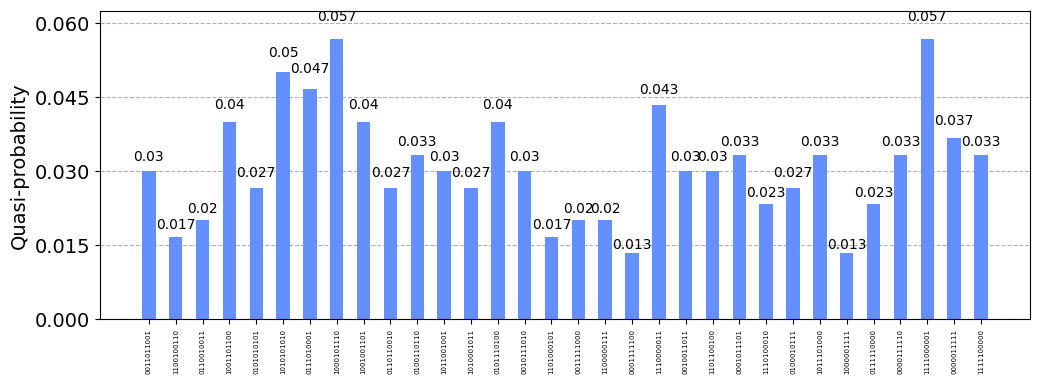

In [139]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution(samples, problem='clustering')

### Solve QUBO via Numpy Exact Solver

In [140]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q)

# Numpy Exact Solver
numpy_solver = NumPyMinimumEigensolver()
optimizer = MinimumEigenOptimizer(numpy_solver)
result = optimizer.solve(qp)
ref_value = result.fval
print('optimal objective value: ', ref_value, '\n', 'optimal solution: ', result.x)

optimal objective value:  0.5192333163432704 
 optimal solution:  [1. 0. 0. 1. 0. 1. 1. 0. 0. 1.]


In [141]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

is_valid_clustering(clusters)

(False, [[3, 2], [0, 4, 1]])

### Solve QUBO via VQE

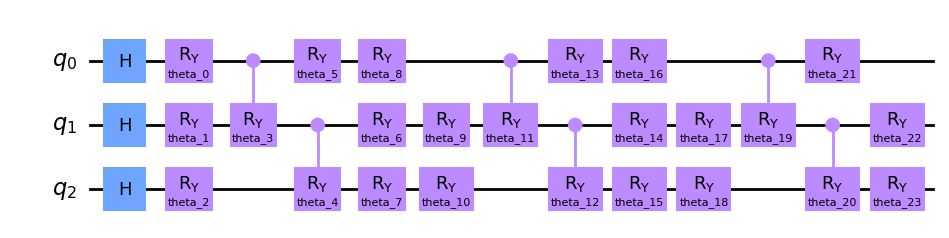

In [142]:
def build_ansatz_circuit(num_qubits, num_layers):

  # instantiate the circuit
  qc = QuantumCircuit(num_qubits)
  theta_idx = 0  # Initialize theta_idx to zero

  # Step 1: Apply Hadamard gates to all qubits
  qc.h(range(num_qubits))

  # Step 2, 3, and 4: Apply RY rotations and linear entanglement in each layer
  for layer in range(num_layers):
    # Apply RY rotations to each qubit in the current layer
    for qubit in range(num_qubits):
        theta = Parameter(f'theta_{theta_idx}')
        qc.ry(theta, qubit)
        theta_idx += 1  # Increment theta_idx

    # Apply linear entanglement using Controlled-RY gates in the current layer
    for qubit in range(num_qubits - 1):
        control_qubit = qubit
        target_qubit = qubit + 1
        theta = Parameter(f'theta_{theta_idx}')
        qc.cry(theta, control_qubit, target_qubit)
        theta_idx += 1  # Increment theta_idx

    # Apply RY rotations to each qubit again in the current layer
    for qubit in range(num_qubits):
        theta = Parameter(f'theta_{theta_idx}')
        qc.ry(theta, qubit)
        theta_idx += 1  # Increment theta_idx

  return qc

ansatz_circuit = build_ansatz_circuit(3, 3)

ansatz_circuit.draw(output='mpl')

In [143]:
classic_optimizer = [ADAM, AQGD, CG, COBYLA, L_BFGS_B,
                     GradientDescent, NELDER_MEAD, NFT, P_BFGS, POWELL,
                     SLSQP, SPSA, QNSPSA, TNC, SciPyOptimizer, UMDA]

In [144]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q)

# print Quadratic Program
print(qp.prettyprint())

# Choose the classical optimizer
classic_optimizer = classic_optimizer[11](maxiter=125)

max_depth = 3
circuit_depth = 0

while circuit_depth < max_depth:

  # increase circuit depth
  circuit_depth += 1
  print('current circuit depth: ', circuit_depth)

  # Lists used in callback function to print the optimization progress
  counts_callback, values_callback = [], []
  # reset callback
  best_params = None
  best_evaluation = float('inf')

  # Define VQE ansatz
  # ansatz = RealAmplitudes(len(qp.variables), entanglement='full', reps=circuit_depth)  # Adjust the number of repetitions (p) as needed
  ansatz = build_ansatz_circuit(len(qp.variables), num_layers=circuit_depth)  # Adjust the number of layers as needed

  if circuit_depth==1:
    initial_point = np.random.uniform(low=-2*np.pi, high=2*np.pi, size=ansatz.num_parameters)

  # Run VQE optimization
  vqe = SamplingVQE(qiskit_sampler, ansatz=ansatz, optimizer=classic_optimizer, callback=store_intermediate_result, initial_point=initial_point)
  optimizer = MinimumEigenOptimizer(vqe)
  result = optimizer.solve(qp)

  # define new set of parameters
  # new_params = list(np.random.uniform(low=-2*np.pi, high=2*np.pi, size=2*len(qp.variables) + len(qp.variables)-1))
  new_params = list(np.random.choice(a=best_params, size=2*len(qp.variables) + len(qp.variables)-1))

  # print(len(best_params), len(new_params))

  # define new set of initial parameters
  initial_point = best_params + new_params

print('optimal objective value: ', result.fval.real, '\n', 'optimal solution: ', result.x)
print(f"Final Energy: {result.fval.real:.5f}")
print(f"Delta from reference energy value is {(result.fval.real - ref_value):.5f}")

Problem name: 

Minimize
  0.07999996940976796*z[0,0]*z[0,1] + 0.07999832982992099*z[0,0]*z[0,2]
  + 0.07996645373720976*z[0,0]*z[0,3] + 0.07932620530009146*z[0,0]*z[0,4]
  + 0.07999999586006229*z[0,1]*z[0,2] + 0.07999996940976796*z[0,1]*z[0,3]
  + 0.07990881180344456*z[0,1]*z[0,4] + 438*z[0,1]*z[1,1]
  + 0.07998765901959135*z[0,2]*z[0,4] + 0.07999832982992099*z[0,3]*z[0,2]
  + 0.07999832982992099*z[0,3]*z[0,4] + 438*z[0,3]*z[1,3] + 438*z[1,0]*z[0,0]
  + 0.07999996940976796*z[1,0]*z[1,1] + 0.07999832982992099*z[1,0]*z[1,2]
  + 0.07996645373720976*z[1,0]*z[1,3] + 0.07932620530009146*z[1,0]*z[1,4]
  + 438*z[1,2]*z[0,2] + 0.07999999586006229*z[1,2]*z[1,1]
  + 0.07999832982992099*z[1,2]*z[1,3] + 0.07998765901959135*z[1,2]*z[1,4]
  + 0.07999996940976796*z[1,3]*z[1,1] + 438*z[1,4]*z[0,4]
  + 0.07990881180344456*z[1,4]*z[1,1] + 0.07999832982992099*z[1,4]*z[1,3]
  - 218.96*z[0,0] - 218.96*z[0,1] - 218.96*z[0,2] - 218.96*z[0,3]
  - 218.96*z[0,4] - 218.96*z[1,0] - 218.96*z[1,1] - 218.96*z[1,2]
 

In [145]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

vqe_clusters_MM = is_valid_clustering(clusters)
print(vqe_clusters_MM)
vqe_clusters_MM = vqe_clusters_MM[1]

(False, [[0, 3, 4], [2, 1]])


In [146]:
# refine the clusters
vqe_clusters_MM = check_capacity_constraints(G_inv, vqe_clusters_MM)
vqe_clusters_MM = check_depot_connection(G_inv, vqe_clusters_MM)
for comm in vqe_clusters_MM:
  if 0 not in comm:
    comm.append(0)
vqe_clusters_MM

[[0, 3, 4], [2, 1, 0]]

Text(0.5, 1.0, 'Convergence')

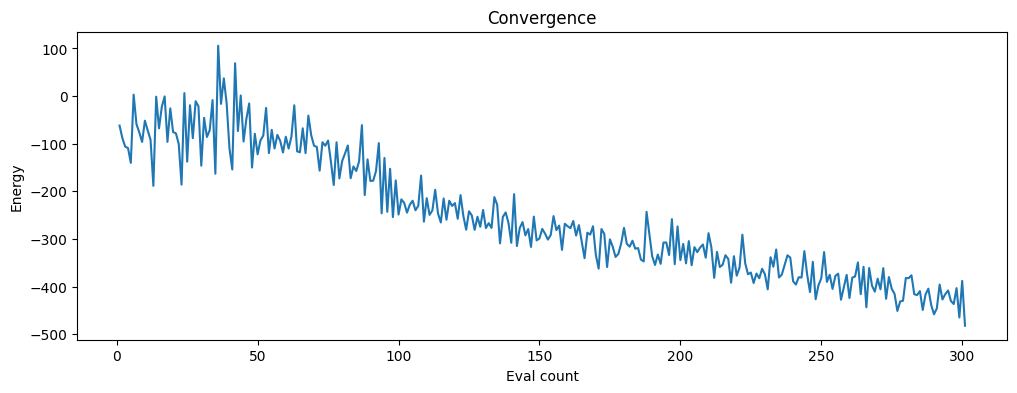

In [147]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_callback, values_callback)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence")

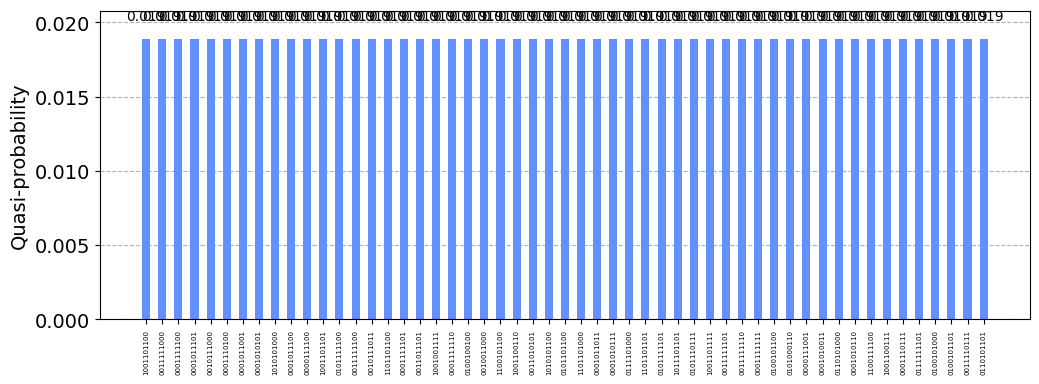

In [148]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution_VQA(qp, result, problem='clustering')

In [149]:
# # print the Ansatz (smaller version for better visualization)
# ansatz = RealAmplitudes(3, entanglement='full', reps=2)
# ansatz.decompose().draw(output='mpl')

In [150]:
# samples = []
# probabilities = []
# fval = []
# for s in result.samples:
#   x = ''
#   for v in range(k):
#     for i in range(n):
#       x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))
#   samples.append(x)
#   probabilities.append(s.probability)
#   fval.append(s.fval)

# sum([probabilities[i] for i in range(len(samples)) if fval[i]==237.0])

### Solve QUBO via QAOA

In [151]:
classic_optimizer = [ADAM, AQGD, CG, COBYLA, L_BFGS_B,
                     GradientDescent, NELDER_MEAD, NFT, P_BFGS, POWELL,
                     SLSQP, SPSA, QNSPSA, TNC, SciPyOptimizer, UMDA]

In [152]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q)

# print Quadratic Program
print(qp.prettyprint())

# Choose the classical optimizer
classic_optimizer = classic_optimizer[11](maxiter=125)

max_depth = 1
circuit_depth = 0

while circuit_depth < max_depth:

  # increase circuit depth
  circuit_depth += 1
  print('current circuit depth: ', circuit_depth)

  # Lists used in callback function to print the optimization progress
  counts_callback, values_callback = [], []
  # reset callback
  best_params = None
  best_evaluation = float('inf')

  if circuit_depth==1:
    initial_point = np.random.uniform(low=0, high=2*np.pi, size=2)

  # Run QAOA optimization
  qaoa = QAOA(qiskit_sampler, reps=circuit_depth, optimizer=classic_optimizer, callback=store_intermediate_result, initial_point=initial_point)
  optimizer = MinimumEigenOptimizer(qaoa)
  result = optimizer.solve(qp)

  # get gamma parameters
  gamma = best_params[::2]
  gamma.insert(0, 0)
  gamma.append(0)

  # get beta parameters
  beta = best_params[1::2]
  beta.insert(0, 0)
  beta.append(0)

  # define new gamma parameters by linearly interpolating previous gamma
  new_gamma = []
  for i in range(1, circuit_depth+2):
    new_gamma.append((i-1)/circuit_depth*gamma[i-1] + (circuit_depth-i+1)/circuit_depth*gamma[i])

  # define new beta parameters by linearly interpolating previous gamma
  new_beta = []
  for i in range(1, circuit_depth+2):
    new_beta.append((i-1)/circuit_depth*beta[i-1] + (circuit_depth-i+1)/circuit_depth*beta[i])

  initial_point = []
  for i in range(len(new_gamma)):
    initial_point.append(new_gamma[i])
    initial_point.append(new_beta[i])

print('optimal objective value: ', result.fval.real, '\n', 'optimal solution: ', result.x)
print(f"Final Energy: {result.fval.real:.5f}")
print(f"Delta from reference energy value is {(result.fval.real - ref_value):.5f}")

Problem name: 

Minimize
  0.07999996940976796*z[0,0]*z[0,1] + 0.07999832982992099*z[0,0]*z[0,2]
  + 0.07996645373720976*z[0,0]*z[0,3] + 0.07932620530009146*z[0,0]*z[0,4]
  + 0.07999999586006229*z[0,1]*z[0,2] + 0.07999996940976796*z[0,1]*z[0,3]
  + 0.07990881180344456*z[0,1]*z[0,4] + 438*z[0,1]*z[1,1]
  + 0.07998765901959135*z[0,2]*z[0,4] + 0.07999832982992099*z[0,3]*z[0,2]
  + 0.07999832982992099*z[0,3]*z[0,4] + 438*z[0,3]*z[1,3] + 438*z[1,0]*z[0,0]
  + 0.07999996940976796*z[1,0]*z[1,1] + 0.07999832982992099*z[1,0]*z[1,2]
  + 0.07996645373720976*z[1,0]*z[1,3] + 0.07932620530009146*z[1,0]*z[1,4]
  + 438*z[1,2]*z[0,2] + 0.07999999586006229*z[1,2]*z[1,1]
  + 0.07999832982992099*z[1,2]*z[1,3] + 0.07998765901959135*z[1,2]*z[1,4]
  + 0.07999996940976796*z[1,3]*z[1,1] + 438*z[1,4]*z[0,4]
  + 0.07990881180344456*z[1,4]*z[1,1] + 0.07999832982992099*z[1,4]*z[1,3]
  - 218.96*z[0,0] - 218.96*z[0,1] - 218.96*z[0,2] - 218.96*z[0,3]
  - 218.96*z[0,4] - 218.96*z[1,0] - 218.96*z[1,1] - 218.96*z[1,2]
 

In [153]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

qaoa_clusters_MM = is_valid_clustering(clusters)
print(qaoa_clusters_MM)
qaoa_clusters_MM = qaoa_clusters_MM[1]

(False, [[3, 2], [0, 4, 1]])


In [154]:
# refine the clusters
qaoa_clusters_MM = check_capacity_constraints(G_inv, qaoa_clusters_MM)
qaoa_clusters_MM = check_depot_connection(G_inv, qaoa_clusters_MM)
for comm in qaoa_clusters_MM:
  if 0 not in comm:
    comm.append(0)
qaoa_clusters_MM

[[3, 2, 0], [0, 4, 1]]

Text(0.5, 1.0, 'Convergence')

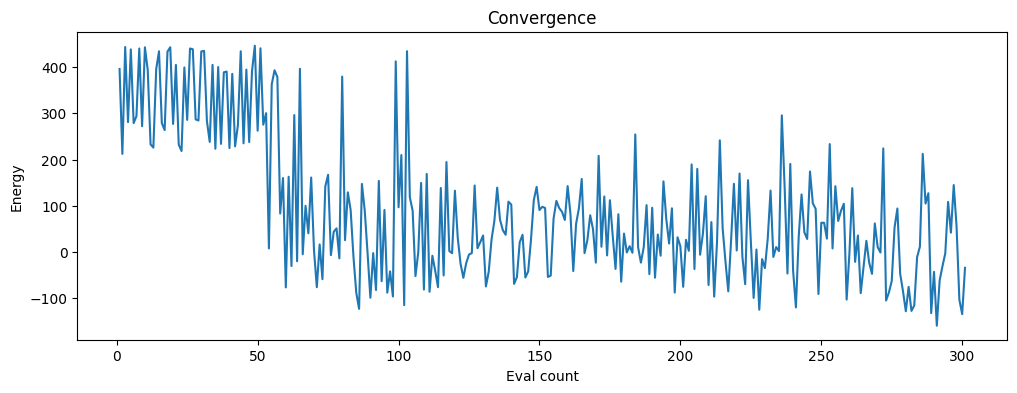

In [155]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_callback, values_callback)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence")

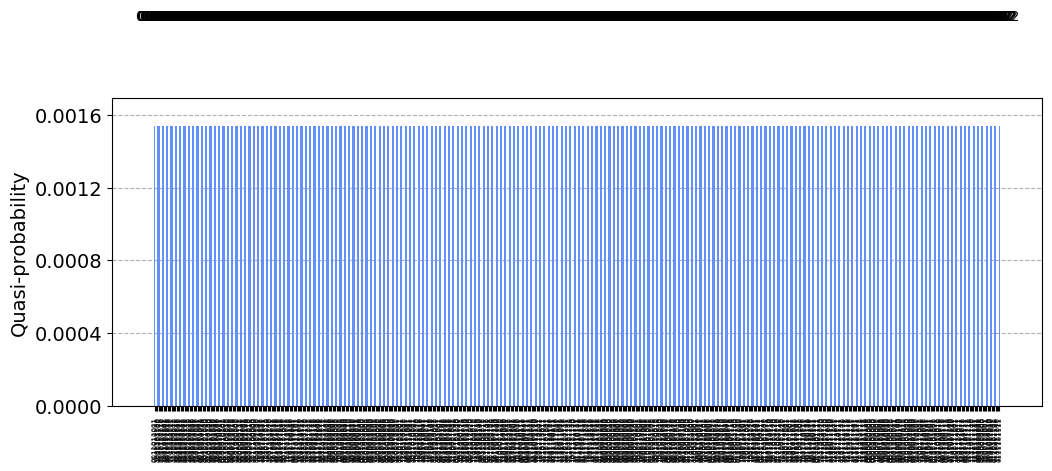

In [156]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution_VQA(qp, result, problem='clustering')

In [157]:
# samples = []
# probabilities = []
# fval = []
# for s in result.samples:
#   x = ''
#   for v in range(k):
#     for i in range(n):
#       x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))
#   samples.append(x)
#   probabilities.append(s.probability)
#   fval.append(s.fval)

# sum([probabilities[i] for i in range(len(samples)) if fval[i]==74.0])

## Graver Augmented Multiseed Algorithm

### Define decision variables

In [158]:
# use Gurobi and build the model by sequentially adding constraints
# After that we'll use gurobipy library to retrieve the constraint matrix

# Declare and initialize model
m = gp.Model('Modularity_Maximization_GAMA')

# Create edges variables
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = m.addVar(vtype=GRB.BINARY, name=f"z[{v},{i}]")

m.update()

### Define constraints

In [159]:
# each node in exactly one cluster (each customer served by exactly one vehicle)
m.addConstrs((sum(z[(v, i)] for v in range(k)) == 1 for i in range(n)), name='each_node_to_one_cluster')

# update model
m.update()

### Define objective

In [160]:
# Objective: maximize modularity
obj = np.sum([(E_inv[i,j]-(in_degree(i)*out_degree(j)/num_edges))*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)])*(1/num_edges)

m.setObjective(obj, GRB.MAXIMIZE)

# update model
m.update()

### Optimize the model via Gurobi

In [161]:
# Save model for inspection
m.write('Modularity_Maximization_GAMA.lp')
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 5 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x12e286d4
Model has 30 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.9991841
Presolve removed 5 rows and 5 columns
Presolve time: 0.00s
Presolved: 6 rows, 11 columns, 18 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)
Found heuristic solution: objective -0.5192910

Root relaxation: objective -3.596455e-01, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

In [162]:
# get non zero decision variables (only x's)
clusters = []
for v in m.getVars():
  if v.varName[0]=='z' and v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    clusters.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_clustering(clusters)

(False, [[0, 1, 4], [2, 3]])

### Retrieve constraint matrix

In [163]:
# Get the constraint matrix A and vector b (Ax=b) from Gurobi model
m.update()
# x = m.getVars()
A = m.getA()
A = A.toarray()
b = np.array(m.getAttr("RHS", m.getConstrs()), int)

# create decision variables
x = Array.create('x', shape=(A.shape[1]), vartype='BINARY')

In [164]:
# Objective function definition
def f(x):
  y = x[:k*n, ]
  y = y.reshape((k, n))
  # Objective: maximize modularity
  obj = np.sum([(E_inv[i,j]-(in_degree(i)*out_degree(j)/num_edges))*y[v,i]*y[v,j]
                for i in range(n)
                for j in range(n)
                for v in range(k)])*(1/num_edges)
  return -obj

# Constraints satisfaction
def const(x):
    return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

In [165]:
# # check gurobi solution
# var = np.array([v.x for v in m.getVars()])
# print(np.dot(A,var)-b) # feasibility
# print(np.dot(obj_coeffs, var)) # obj value

### Graver Augmentation

In [166]:
# compute graver basis elements
graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
print(len(graver_elems), ' graver elements found.')

3  graver elements found.


In [167]:
# compute feasible solutions
feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
print(len(feas_sols), ' feasible solutions found.')

32  feasible solutions found.


In [168]:
# Multiseed Augmentation
final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

# get best solution
x_opt = final_sols[np.argmin(final_obj_full), :]
print(x_opt, np.min(final_obj_full))

[0. 0. 1. 1. 0. 1. 1. 0. 0. 1.] 0.519233316343225


In [169]:
clusters = []
for v in range(k):
  for i in range(n):
    clusters.append((v,i))

clusters = [clusters[i] for i in range(len(clusters)) if x_opt[i]>1e-6]

print(clusters)

gama_clusters_MM = is_valid_clustering(clusters)
print(gama_clusters_MM)
gama_clusters_MM = gama_clusters_MM[1]

[(0, 2), (0, 3), (1, 0), (1, 1), (1, 4)]
(False, [[2, 3], [0, 1, 4]])


In [170]:
# refine the clusters
gama_clusters_MM = check_capacity_constraints(G_inv, gama_clusters_MM)
gama_clusters_MM = check_depot_connection(G_inv, gama_clusters_MM)
for comm in gama_clusters_MM:
  if 0 not in comm:
    comm.append(0)
gama_clusters_MM

[[2, 3, 0], [0, 1, 4]]

# 2-Phase Heuristic: Routing (Travelling Salesman Problem)

## Formulation with DFJ Method for sequential subtour elimination

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij}x_{ij} \\
\text{subject to} \quad & \sum_{j \in N^{+}(i)} x_{ij} = 1 \quad \forall i \in Cluster\\
& \sum_{i \in N^{-}(j)} x_{ij} = 1 \quad \forall j \in Cluster\\
& \sum_{i \in S} \sum_{j \notin S} x_{ij} \geq 1 \quad \forall S \;\;\text{subtour}\\
& x_{ij} \in \{0, 1\} \quad \forall i,j \in Cluster
\end{alignat*}

In [171]:
# choose clusters
clusters = gurobi_clusters
print('gurobi', clusters)
# clusters = annealing_clusters
# print('annealing', clusters)
# clusters = vqe_clusters
# print('vqe', clusters)
# clusters = qaoa_clusters
# print('qaoa', clusters)
# # clusters = wsqaoa_clusters
# # print('wsqaoa', clusters)
# clusters = gama_clusters
# print('gama', clusters)
# clusters = louvain_clusters
# print('louvain', clusters)

# # clusters found via Modularity Maximization
# clusters = gurobi_clusters_MM
# print('gurobi_MM', clusters)
# clusters = annealing_clusters_MM
# print('annealing_MM', clusters)
# clusters = vqe_clusters_MM
# print('vqe_MM', clusters)
# clusters = qaoa_clusters_MM
# print('qaoa_MM', clusters)
# clusters = gama_clusters_MM
# print('gama_MM', clusters)

# clusters = [[1,0], [2,3,4,0]]
# print(clusters)

gurobi [[0, 2, 3], [0, 1, 4]]


## Gurobi

In [172]:
# solve TSP individually on each cluster
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_gurobi(cluster)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 6 rows, 6 columns and 12 nonzeros
Model fingerprint: 0x8bd581c9
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 30 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+01, best bound 3.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|

In [173]:
tsp_solutions.values()

dict_values([([(0, 2), (2, 3), (3, 0)], 30.0), ([(0, 1), (1, 4), (4, 0)], 27.0)])

## QUBO

### Quantum Annealing

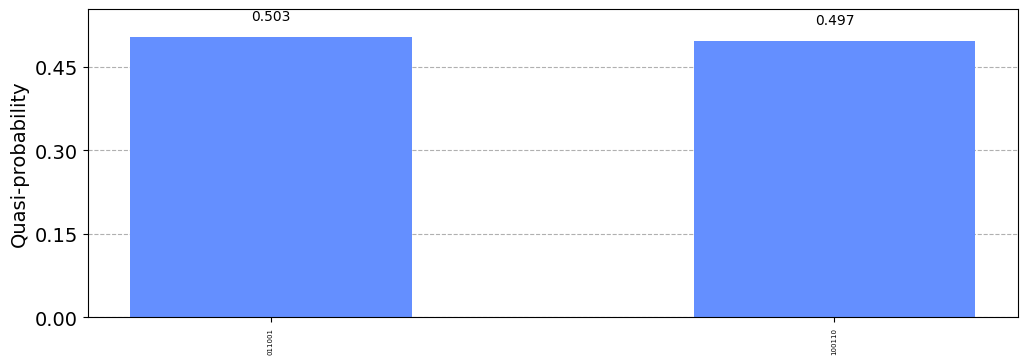

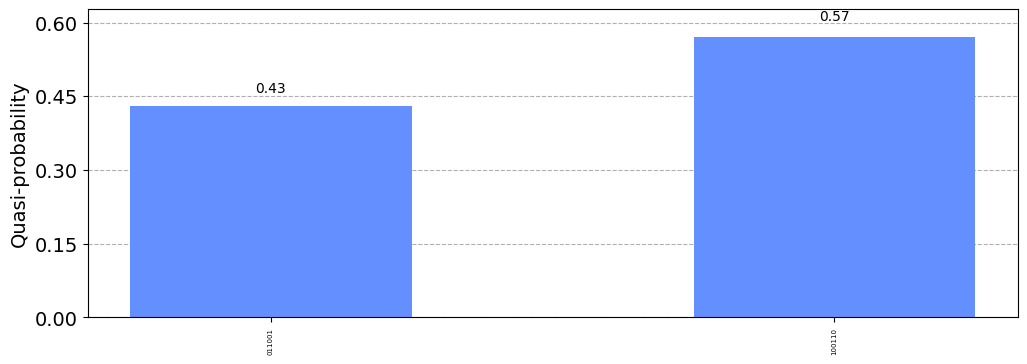


dict_values([([(0, 3), (2, 0), (3, 2)], 30), ([(0, 4), (1, 0), (4, 1)], 27)])


In [174]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo(cluster, p, show_hist=True)

print()
print(tsp_solutions.values())

### Numpy Exact Eigensolver

In [175]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo_VQA(cluster, p, VQA='Numpy')

print(tsp_solutions.values())

dict_values([([(0, 3), (2, 0), (3, 2)], 30.0), ([(0, 1), (1, 4), (4, 0)], 27.0)])


### VQE

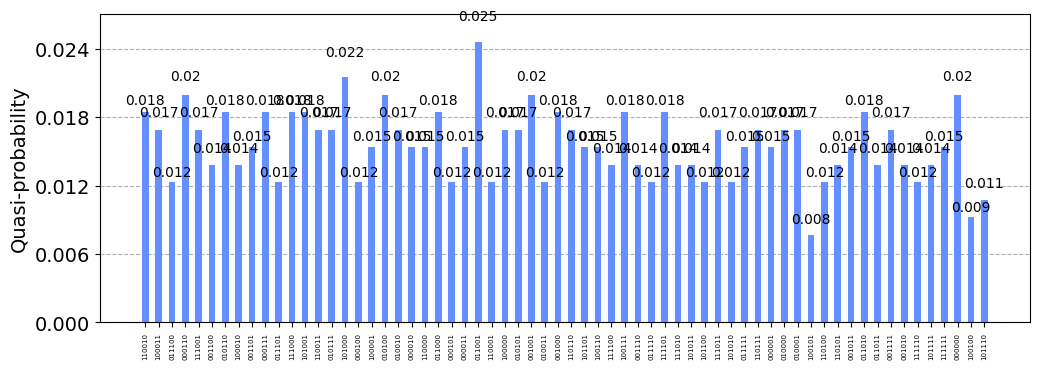

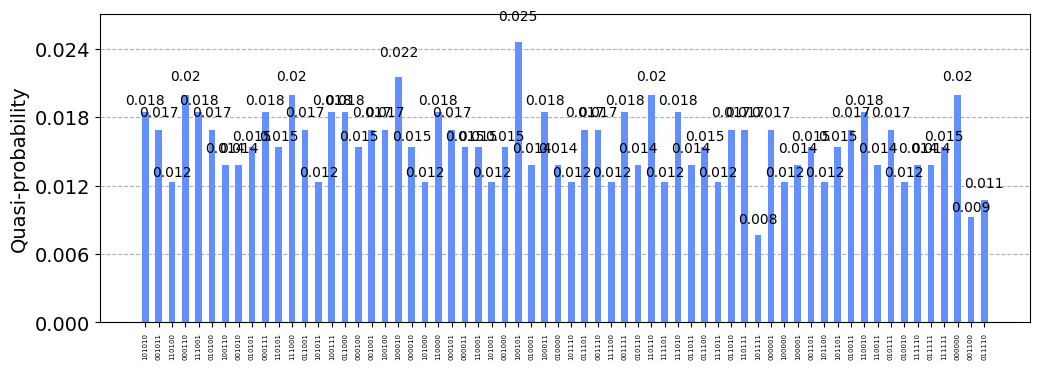


dict_values([([(0, 3), (2, 0), (3, 2)], 30.0), ([(0, 4), (1, 0), (4, 1)], 27.0)])


In [176]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo_VQA(cluster, p, VQA='VQE', circuit_depth=1, show_hist=True)

print()
print(tsp_solutions.values())

### QAOA

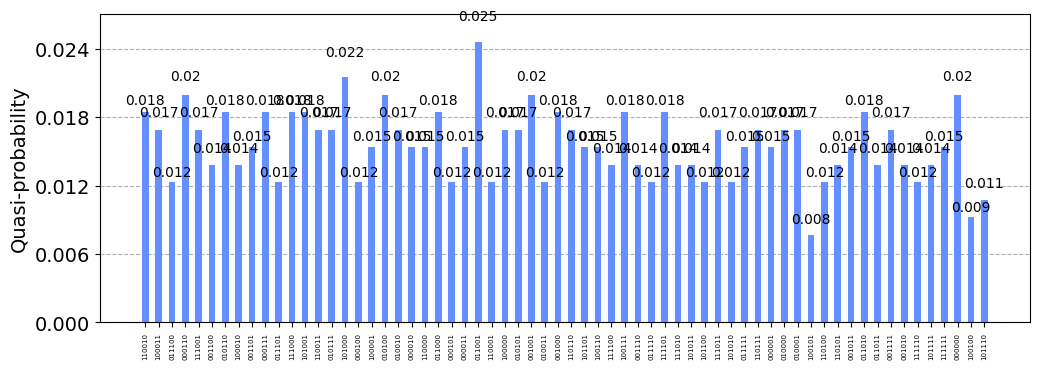

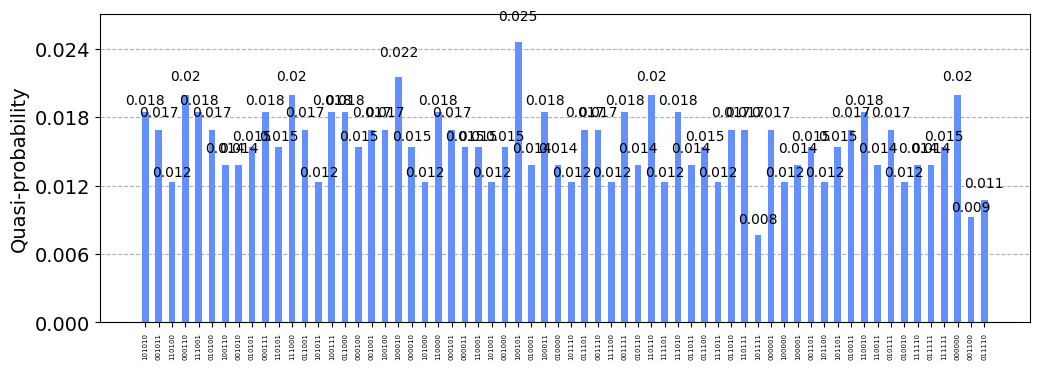


dict_values([([(0, 2), (2, 3), (3, 0)], 30.0), ([(0, 1), (1, 4), (4, 0)], 27.0)])


In [177]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo_VQA(cluster, p, VQA='QAOA', circuit_depth=1, show_hist=True)

print()
print(tsp_solutions.values())

## Graver Augmented Multiseed Algorithm

In [178]:
# solve TSP individually on each cluster
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_gama(cluster)

tsp_solutions.values()

dict_values([([(0, 3), (2, 0), (3, 2)], 30.0), ([(0, 4), (1, 0), (4, 1)], 27.0)])

# 2-Phase Heuristic: Routing (TSP second formulation)

## Formulation

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij} \sum_{t=0}^{|Cluster|-1}x_{i,t}x_{j, t+1}\\
\text{subject to} \quad & \sum_{t} x_{i,t} = 1 \quad \forall i \in Cluster\\
& \sum_{i} x_{i,t} = 1 \quad \forall t = 0, \dots, |Cluster|-1\\
& x_{i,t} \in \{0, 1\} \quad \forall i \in Cluster, \forall t = 0, \dots, |Cluster|-1\\
\end{alignat*}

In [179]:
# choose clusters
clusters = gurobi_clusters
print(clusters)
# clusters = annealing_clusters
# print(clusters)
# clusters = vqe_clusters
# print(clusters)
# clusters = qaoa_clusters
# print(clusters)
# clusters = wsqaoa_clusters
# print(clusters)
# clusters = gama_clusters
# print(clusters)
# clusters = louvain_clusters
# print(clusters)

# clusters = [[1,0], [2,3,4,0]]
# print(clusters)

[[0, 2, 3], [0, 1, 4]]


## Gurobi

In [180]:
# solve TSP individually on each cluster
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP2_gurobi(cluster)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 6 rows, 9 columns and 18 nonzeros
Model fingerprint: 0x947831cf
Model has 12 quadratic objective terms
Variable types: 0 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 18 rows, 21 columns, 54 nonzeros
Variable types: 0 continuous, 21 integer (21 binary)
Found heuristic solution: objective 19.0000000

Root relaxation: objective 0.000000e+00, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  

In [181]:
tsp_solutions.values()

dict_values([(True, [0, 3, 2], 30.0), (True, [0, 4, 1], 27.0)])

## QUBO

### Quantum Annealing

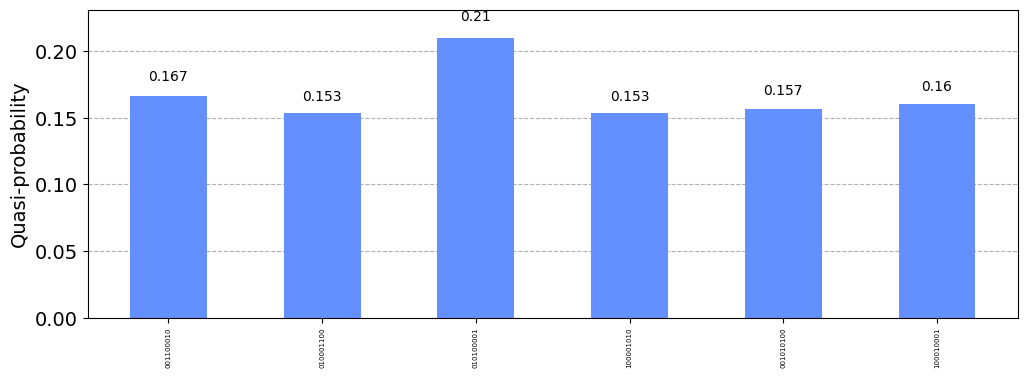

[(2, 0), (3, 1), (0, 2)]


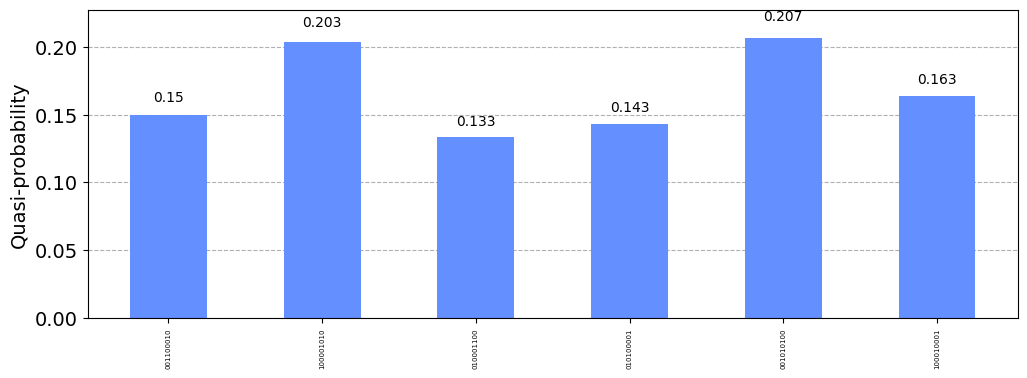

[(1, 0), (4, 1), (0, 2)]

dict_values([(True, [2, 3, 0], 30), (True, [1, 4, 0], 27)])


In [182]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP2_qubo(cluster, p, show_hist=True)

print()
print(tsp_solutions.values())

### Numpy Exact Eigensolver

In [183]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP2_qubo_VQA(cluster, p, VQA='Numpy')

print(tsp_solutions.values())

[(2, 0), (3, 1), (0, 2)]
[(0, 0), (4, 1), (1, 2)]
dict_values([(True, [2, 3, 0], 30.0), (True, [0, 4, 1], 27.0)])


### VQE

[(2, 0), (0, 1), (3, 2)]


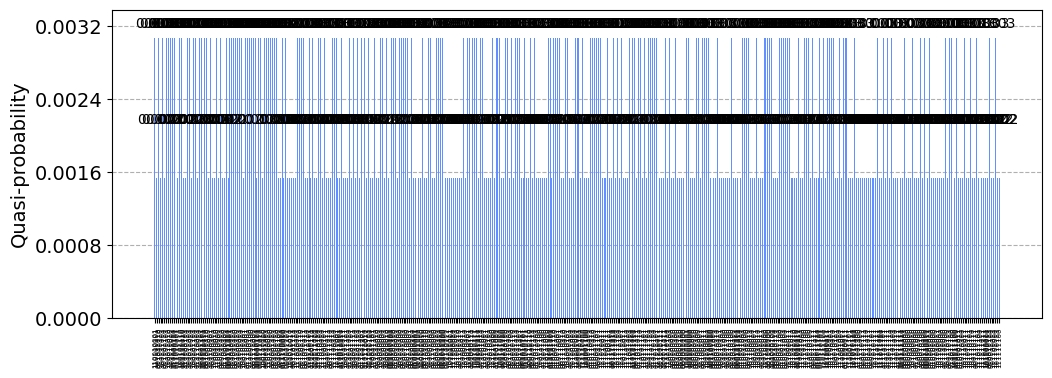

[(4, 0), (1, 1), (0, 2)]


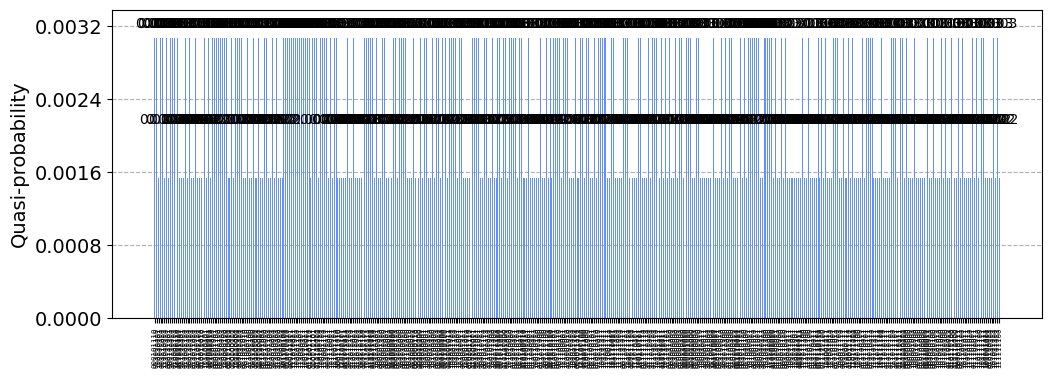


dict_values([(True, [2, 0, 3], 30.0), (True, [4, 1, 0], 27.0)])


In [184]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP2_qubo_VQA(cluster, p, VQA='VQE', circuit_depth=1, show_hist=True)

print()
print(tsp_solutions.values())

### QAOA

[(2, 0), (0, 1), (3, 2)]


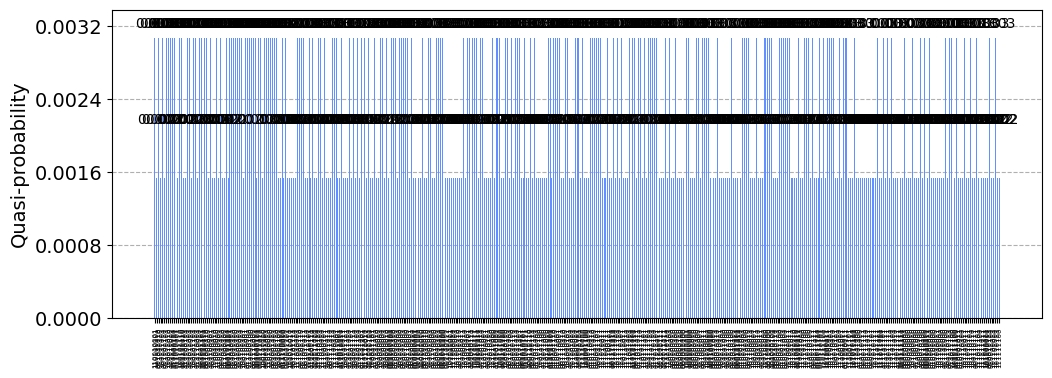

[(0, 0), (4, 1), (1, 2)]


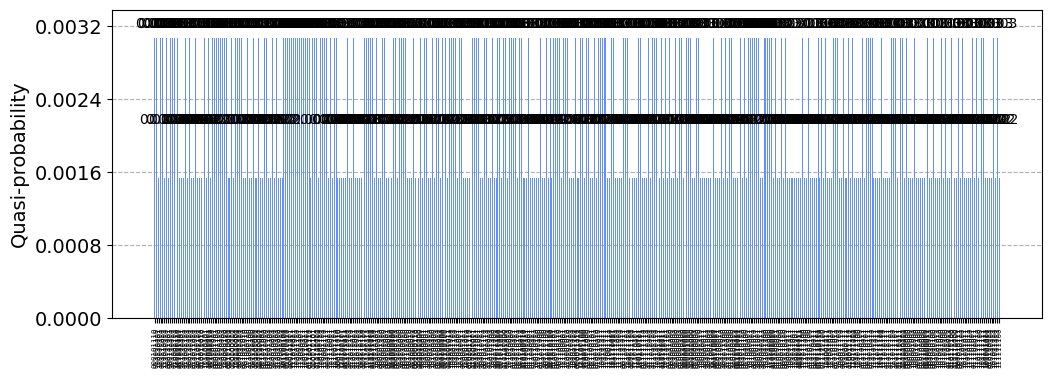


dict_values([(True, [2, 0, 3], 30.0), (True, [0, 4, 1], 27.0)])


In [185]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP2_qubo_VQA(cluster, p, VQA='QAOA', circuit_depth=1, show_hist=True)

print()
print(tsp_solutions.values())

## Graver Augmented Multiseed Algorithm

In [186]:
# solve TSP individually on each cluster
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP2_gama(cluster)

tsp_solutions.values()

[(2, 0), (3, 1), (0, 2)]
[(1, 0), (4, 1), (0, 2)]


dict_values([(True, [2, 3, 0], 30.0), (True, [1, 4, 0], 27.0)])